# Univers d'investissement
# Critères :
# Géographique : Europe
# Sectoriel : technologie, santé, alimentaire, luxe
# Taille de capitalisation : large/mid capitalisation
# Objectif ESG: bonne notation (à définir)

# Profondeur d'Historique: 10 ans
# données mensuel

# Imports


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import os
import pickle
import warnings
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Collecte et traitement des données

In [ ]:
# Chemin de sauvegarde
output_dir = "/content/drive/MyDrive/Colab Notebooks"

# Liste des tickers et colonnes à convertir (numériques)
tickers = [
    "ASML.AS", "SAP.DE", "IFX.DE", "STMPA.PA", "ERIC-B.ST",
    "SAN.PA", "NOVO-B.CO", "BAYN.DE", "ROG.SW", "AZN.L",
    "NESN.SW", "ULVR.L", "BN.PA", "CA.PA", "MC.PA", "KER.PA"
]
cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Dictionnaire pour stocker les DataFrames filtrés par ticker
data_dict = {}

# Période d'analyse et buffer pour les moyennes mobiles
analysis_start = pd.to_datetime("2015-01-01")
analysis_end   = pd.to_datetime("2025-12-31")
buffer_period  = pd.DateOffset(months=20)

# Fonctions de calcul des indicateurs
def get_scalar(x):
    return x.iloc[0] if isinstance(x, pd.Series) else x

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_indicators(df):
    # Travailler sur une copie pour éviter les SettingWithCopyWarning
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['Rendement Cumulatif'] = (1 + df['Return']).cumprod()
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    df['RSI'] = compute_rsi(df['Close'], period=14)
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift()),
        np.abs(df['Low'] - df['Close'].shift())
    ])
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df['Volatilite_12m'] = df['Return'].rolling(window=12).std() * np.sqrt(12)
    df['Cumulative Max'] = df['Rendement Cumulatif'].cummax()
    df['Drawdown'] = df['Rendement Cumulatif'] / df['Cumulative Max'] - 1
    return df

# Lecture des CSV et filtrage avec buffer
for ticker in tickers:
    filename = os.path.join(output_dir, f"data_{ticker}.csv")
    if os.path.exists(filename):
        # Charger le CSV en indexant sur la première colonne (les dates)
        df = pd.read_csv(filename, index_col=0, parse_dates=True)
        # S'assurer que l'index est bien en datetime et supprimer les lignes mal parsées
        df.index = pd.to_datetime(df.index, errors='coerce')
        df = df[df.index.notna()]
        # Conversion des colonnes numériques
        for col in cols_to_convert:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        # Pour le calcul des indicateurs, on utilise les données à partir du buffer (pour avoir suffisamment d'informations)
        df_buffer = df.loc[df.index >= (analysis_start - buffer_period)].copy()
        df_computed = compute_indicators(df_buffer)
        # Ensuite, on ne garde que la période d'analyse 2015-2025
        df_analysis = df_computed.loc[analysis_start:analysis_end].copy()
        data_dict[ticker] = df_analysis
    else:
        print(f"Le fichier pour {ticker} n'existe pas.")

# Concaténer tous les DataFrames du dictionnaire en un seul DataFrame (avec un MultiIndex sur les colonnes)
combined_df = pd.concat(data_dict, axis=1)

# Affichage d'un aperçu du DataFrame combiné
print("Aperçu du DataFrame combiné :")
print(combined_df.head())

for ticker, df in data_dict.items():
    print(f"\nTicker: {ticker}")
    print(df.head())


<ipython-input-27-7acc0adb3492>:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename, index_col=0, parse_dates=True)
<ipython-input-27-7acc0adb3492>:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')
<ipython-input-27-7acc0adb3492>:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename, index_col=0, parse_dates=True)
<ipython-input-27-7acc0adb3492>:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing i

Aperçu du DataFrame combiné :
              ASML.AS                                                       \
                Close       High        Low       Open    Volume    Return   
Price                                                                        
2015-01-01  84.354691  86.642612  76.568520  80.936373  32511395  0.042234   
2015-02-01  87.366074  88.360821  78.666541  83.558900  25651529  0.035699   
2015-03-01  85.720200  92.602052  81.361392  86.977200  29936072 -0.018839   
2015-04-01  87.456497  93.551592  78.621323  84.734501  44265381  0.020255   
2015-05-01  92.662903  95.486046  83.911153  88.073015  21275112  0.059531   

                                                            ... KER.PA  \
           Rendement Cumulatif      SMA20 SMA50        RSI  ...  SMA50   
Price                                                       ...          
2015-01-01            1.466302  64.220135   NaN  74.011706  ...    NaN   
2015-02-01            1.518648  65.874931   NaN  

In [ ]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


output_dir = "/content/drive/MyDrive/Colab Notebooks"
os.makedirs(output_dir, exist_ok=True)

# Liste des tickers
tickers = [
    "ASML.AS", "SAP.DE", "IFX.DE", "STMPA.PA", "ERIC-B.ST",
    "SAN.PA", "NOVO-B.CO", "BAYN.DE", "ROG.SW", "AZN.L",
    "NESN.SW", "ULVR.L", "BN.PA", "CA.PA", "MC.PA", "KER.PA"
]

# Dictionnaire pour stocker les DataFrames par ticker
df_dict = {}

for ticker in tickers:
    filename = os.path.join(output_dir, f"data_{ticker}.csv")

    if os.path.exists(filename):
        # Charger le CSV avec l'index en tant que dates
        df = pd.read_csv(filename, index_col=0, parse_dates=True)
        # Conversion de l'index en datetime
        df.index = pd.to_datetime(df.index, errors='coerce')
        # Garder seulement les lignes dont l'index est valide
        df = df[df.index.notna()]

        # Conversion des colonnes numériques si nécessaire
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df_dict[ticker] = df
    else:
        print(f"Le fichier pour le ticker {ticker} n'existe pas.")

# Enregistrer le dictionnaire dans un fichier pickle pour le recharger rapidement plus tard
output_pickle = os.path.join(output_dir, "df_dict.pkl")
with open(output_pickle, "wb") as f:
    pickle.dump(df_dict, f)

print(f"Le dictionnaire df_dict a été enregistré dans : {output_pickle}")


Le dictionnaire df_dict a été enregistré dans : /content/drive/MyDrive/Colab Notebooks/df_dict.pkl


<ipython-input-28-39b9e39e4ebc>:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename, index_col=0, parse_dates=True)
<ipython-input-28-39b9e39e4ebc>:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')
<ipython-input-28-39b9e39e4ebc>:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename, index_col=0, parse_dates=True)
<ipython-input-28-39b9e39e4ebc>:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing i

In [ ]:


# Chemin du dossier où se trouve le fichier pickle
output_dir = "/content/drive/MyDrive/Colab Notebooks"
output_pickle = os.path.join(output_dir, "df_dict.pkl")

# Ouvrir et charger le dictionnaire depuis le fichier pickle
with open(output_pickle, "rb") as f:
    df_dict = pickle.load(f)

# Afficher les tickers disponibles dans le dictionnaire
print("Tickers chargés :", list(df_dict.keys()))


Tickers chargés : ['ASML.AS', 'SAP.DE', 'IFX.DE', 'STMPA.PA', 'ERIC-B.ST', 'SAN.PA', 'NOVO-B.CO', 'BAYN.DE', 'ROG.SW', 'AZN.L', 'NESN.SW', 'ULVR.L', 'BN.PA', 'CA.PA', 'MC.PA', 'KER.PA']


In [ ]:
df_dict.keys()

dict_keys(['ASML.AS', 'SAP.DE', 'IFX.DE', 'STMPA.PA', 'ERIC-B.ST', 'SAN.PA', 'NOVO-B.CO', 'BAYN.DE', 'ROG.SW', 'AZN.L', 'NESN.SW', 'ULVR.L', 'BN.PA', 'CA.PA', 'MC.PA', 'KER.PA'])

In [ ]:
df_dict['ASML.AS']

Close        High         Low        Open    Volume
Price                                                               
2010-04-01   27.945484   30.644444   27.799291   29.778527  46391443
2010-05-01   26.494793   28.625847   24.346870   27.720569  53234728
2010-06-01   25.713224   28.659588   25.454573   26.185542  40480562
2010-07-01   27.518147   29.126277   24.588650   25.201539  45426047
2010-08-01   22.125851   28.355950   21.760365   27.889253  50223947
...                ...         ...         ...         ...       ...
2024-11-01  656.976440  670.946170  604.390376  618.659444  14928365
2024-12-01  677.232544  720.438910  642.507800  647.995908  13404729
2025-01-01  721.137390  751.272104  617.162679  677.232527  19121187
2025-02-01  677.132751  743.289451  668.551370  693.497317  15276962
2025-03-01  659.400024  698.299988  624.200012  679.000000   8926866

[180 rows x 5 columns]

# Définition d'une stratégie d'investissement

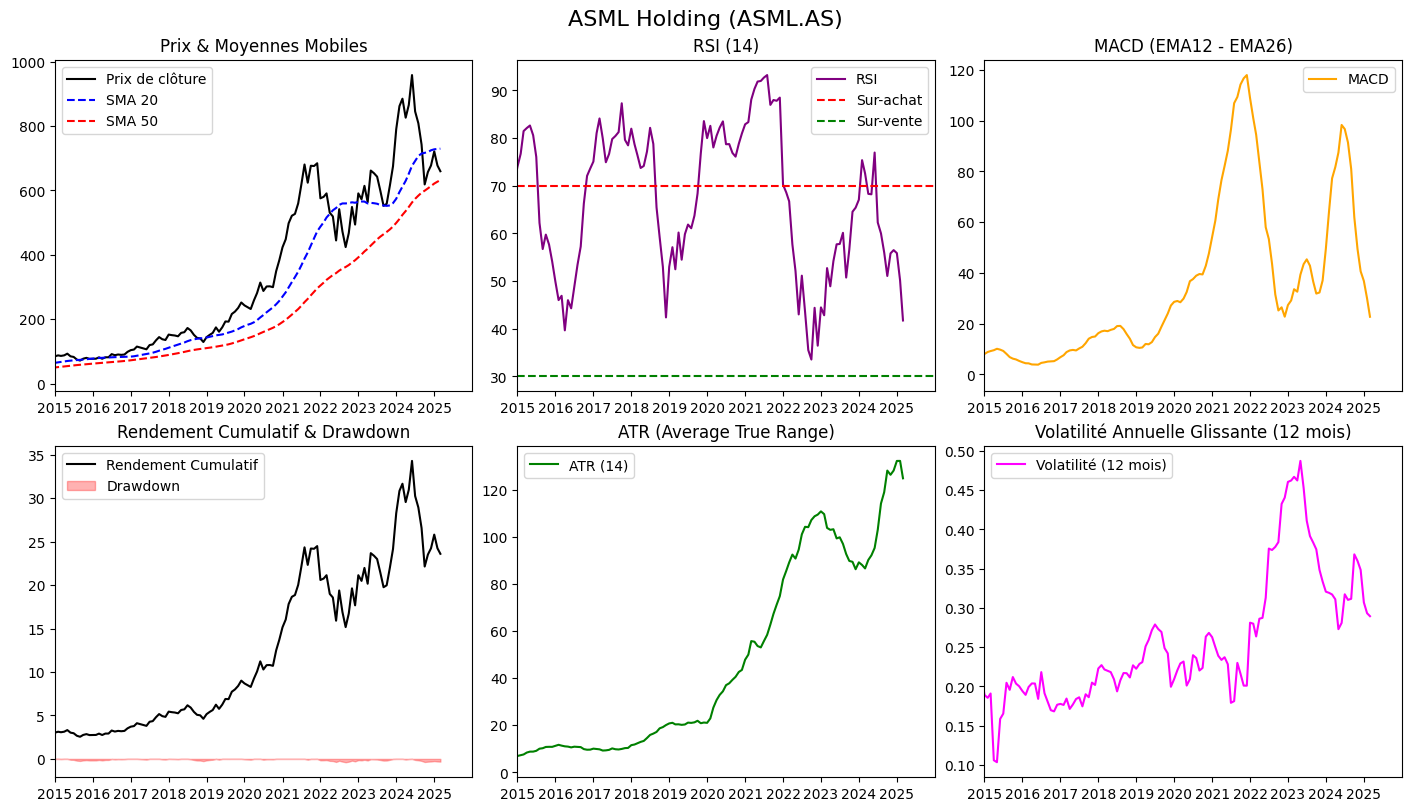

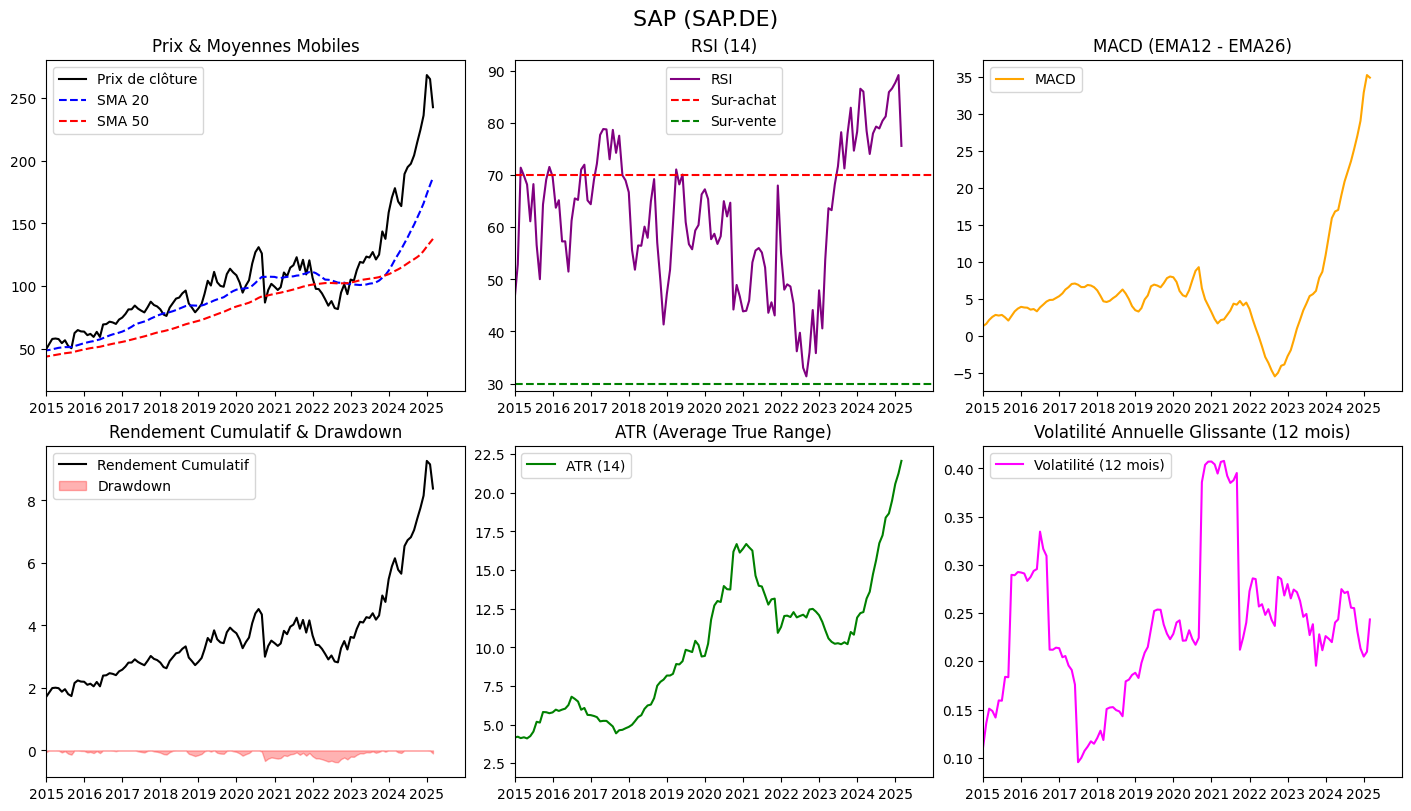

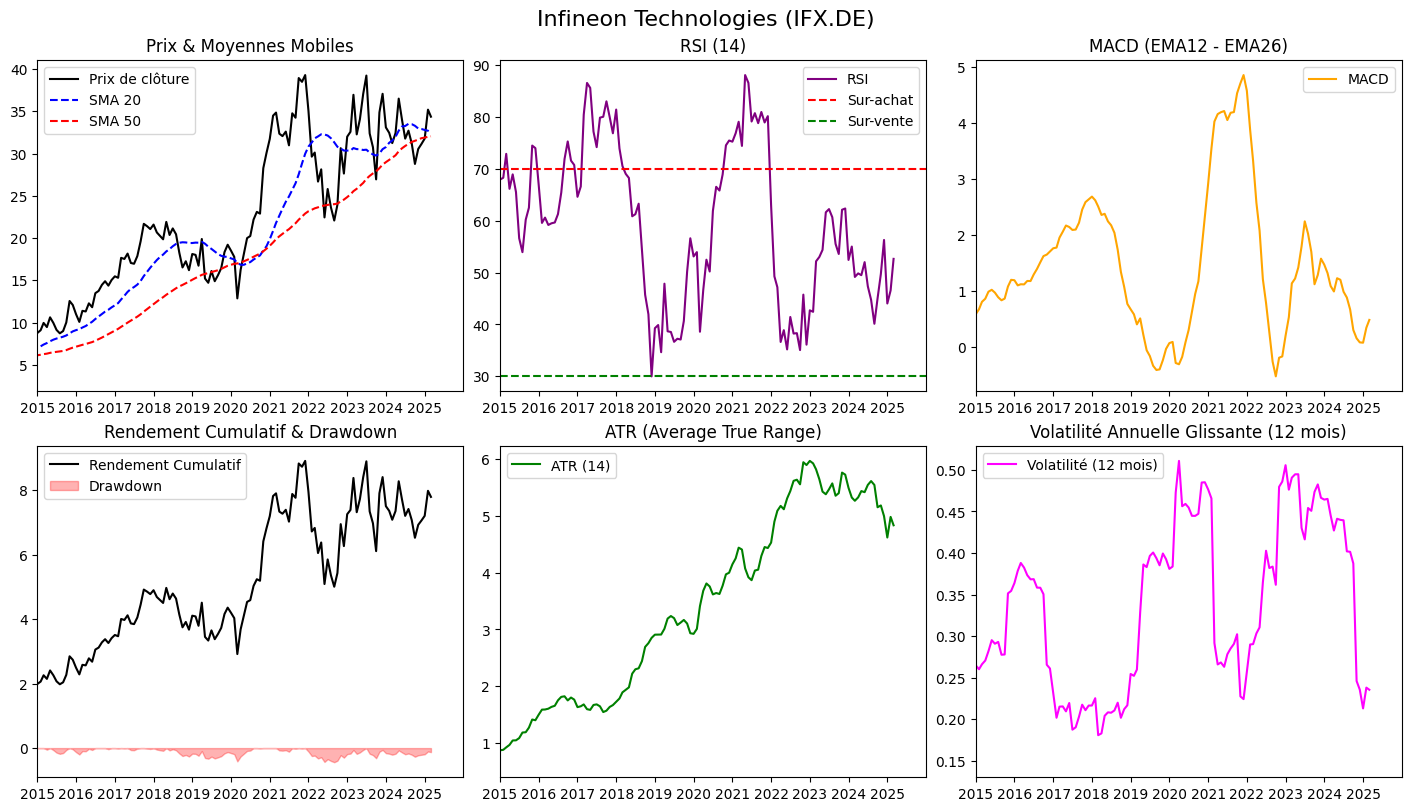

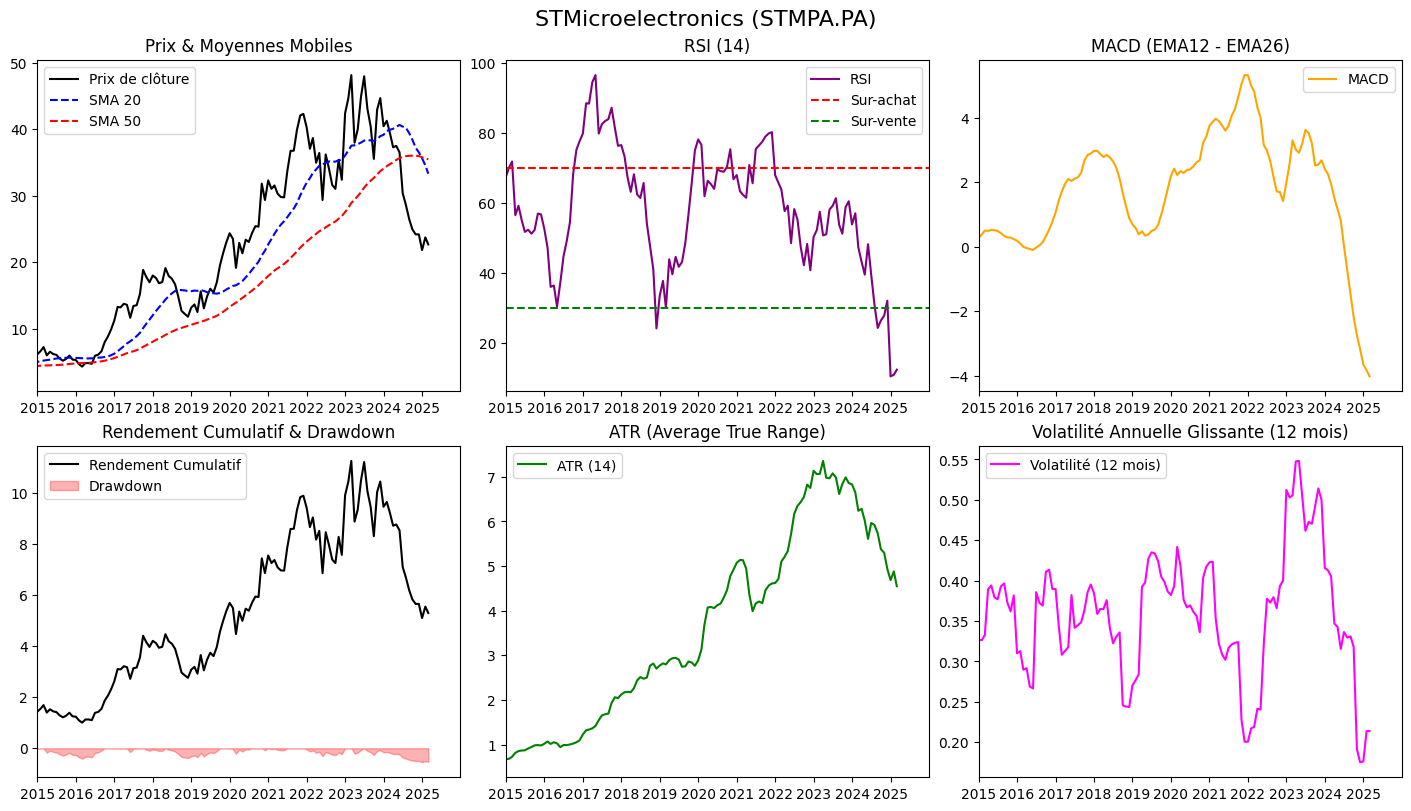

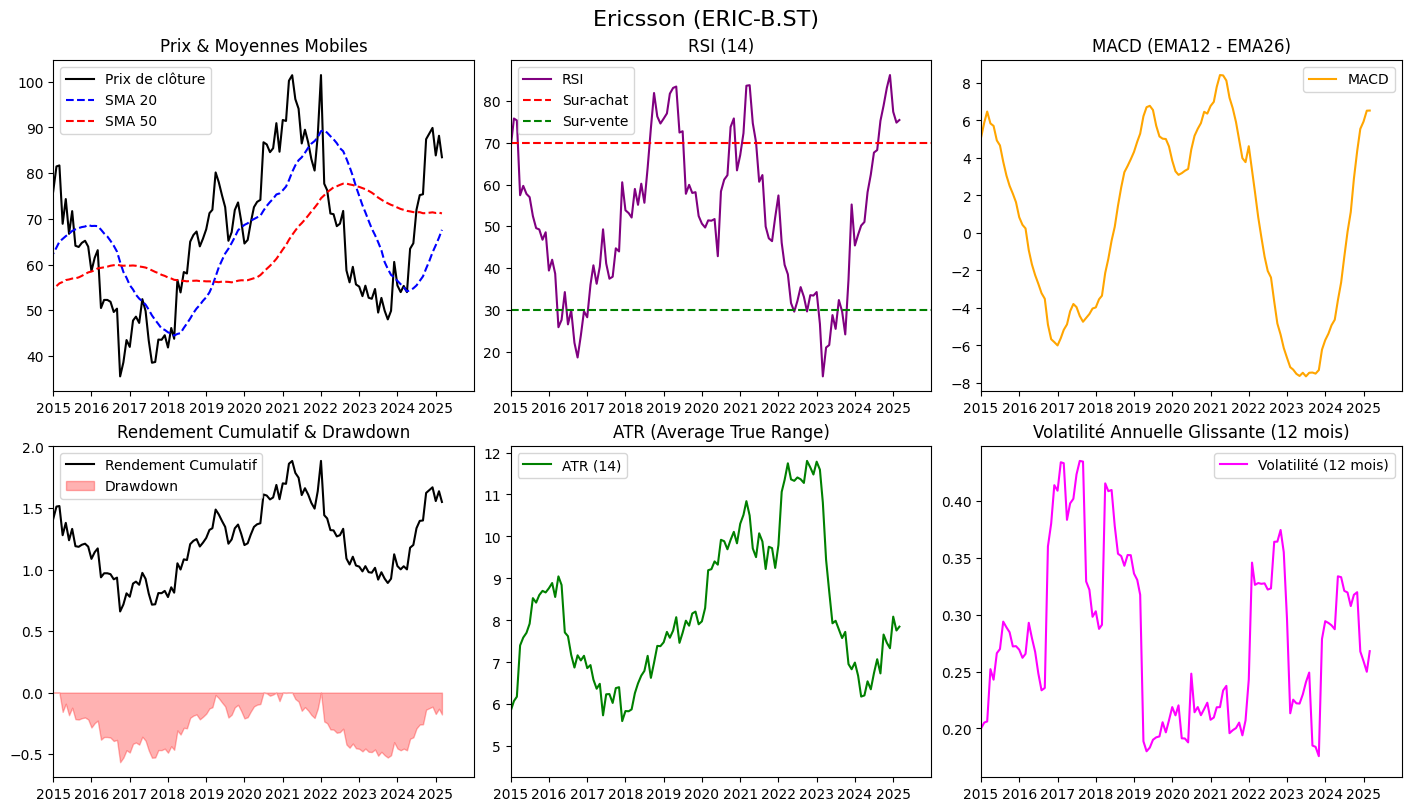

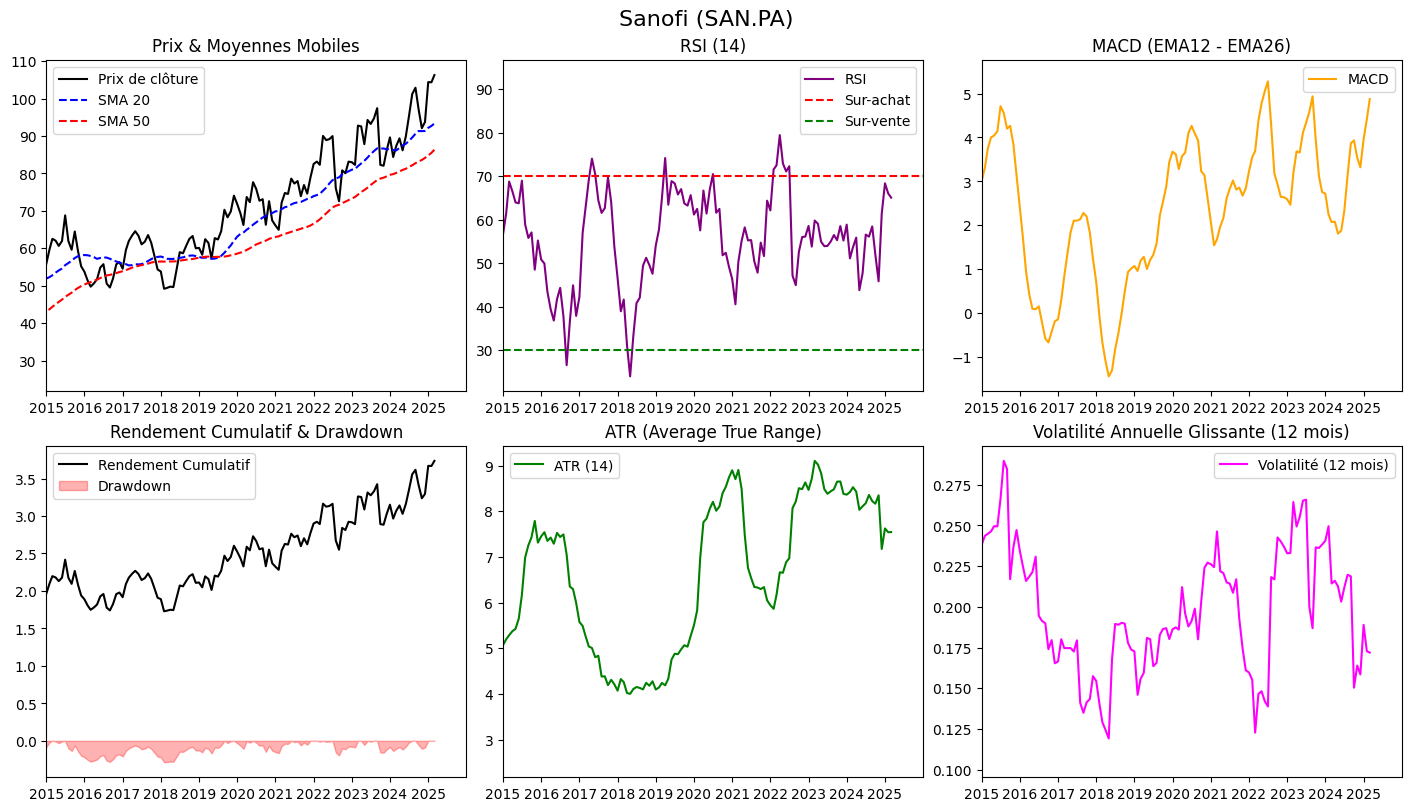

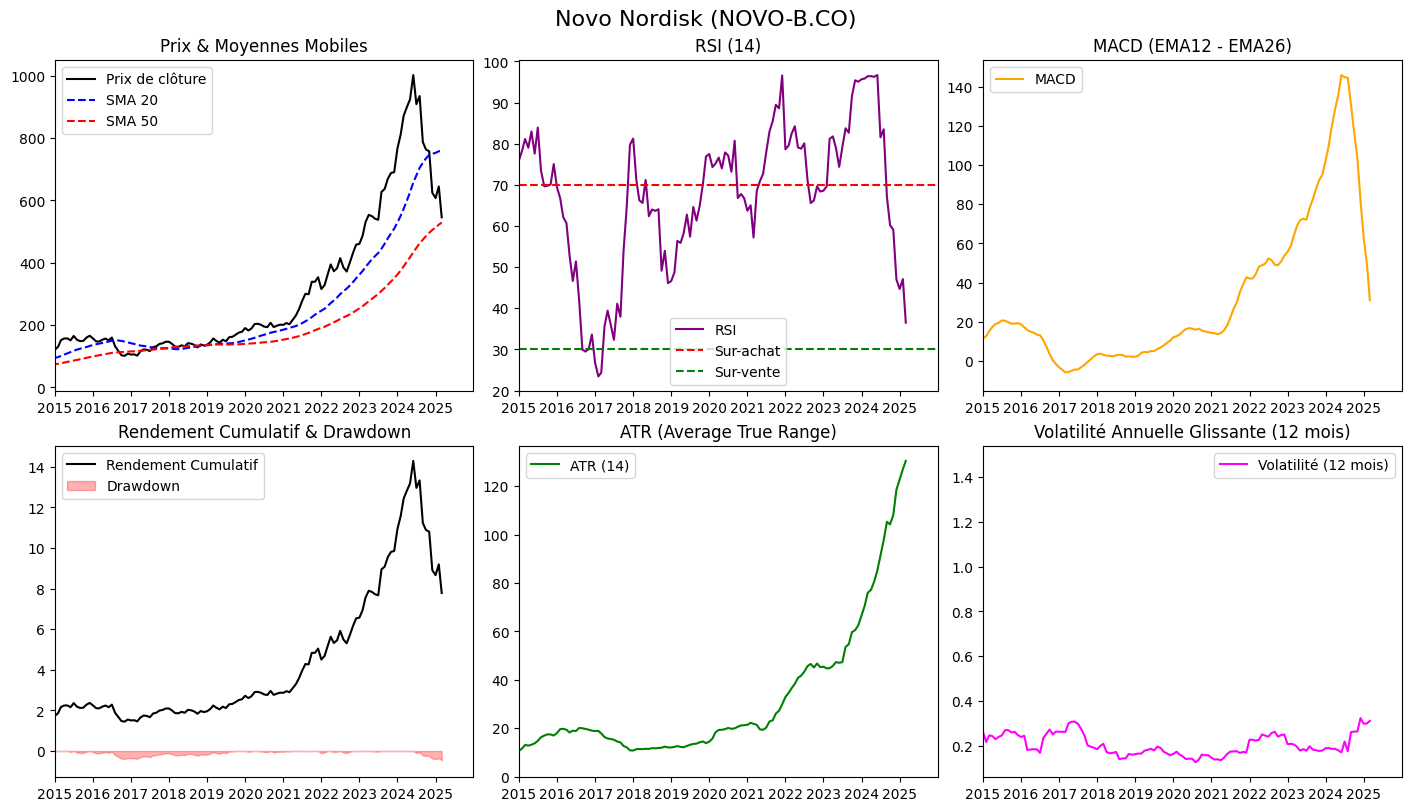

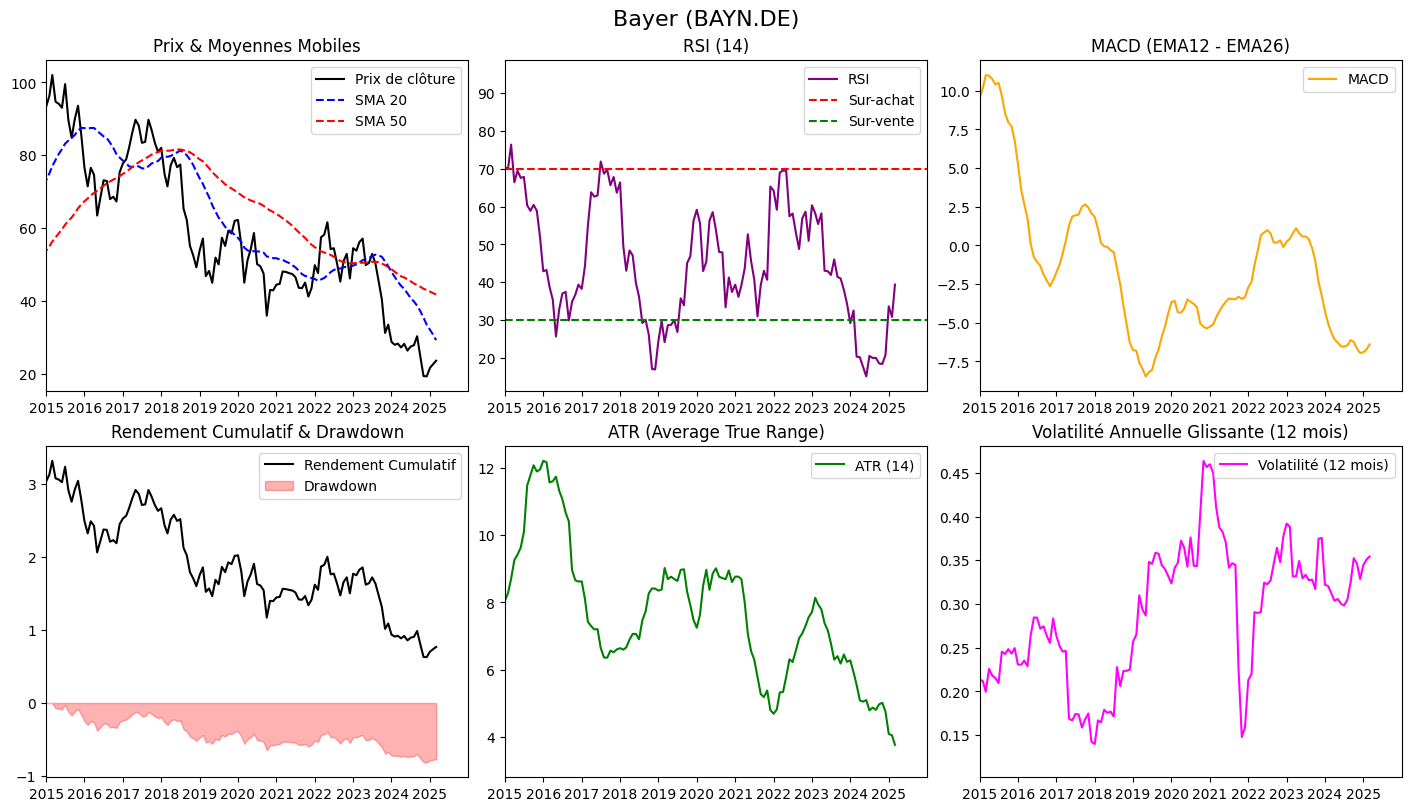

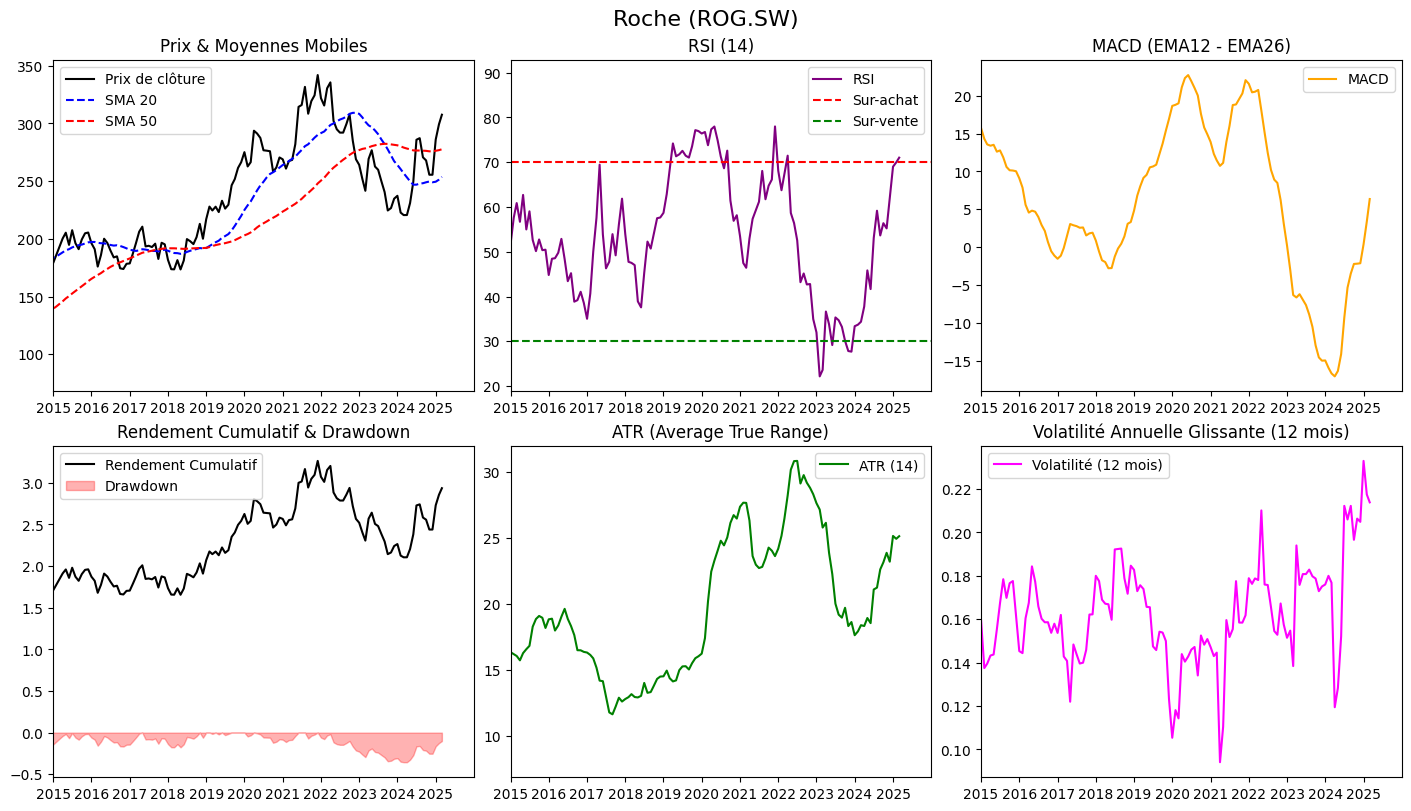

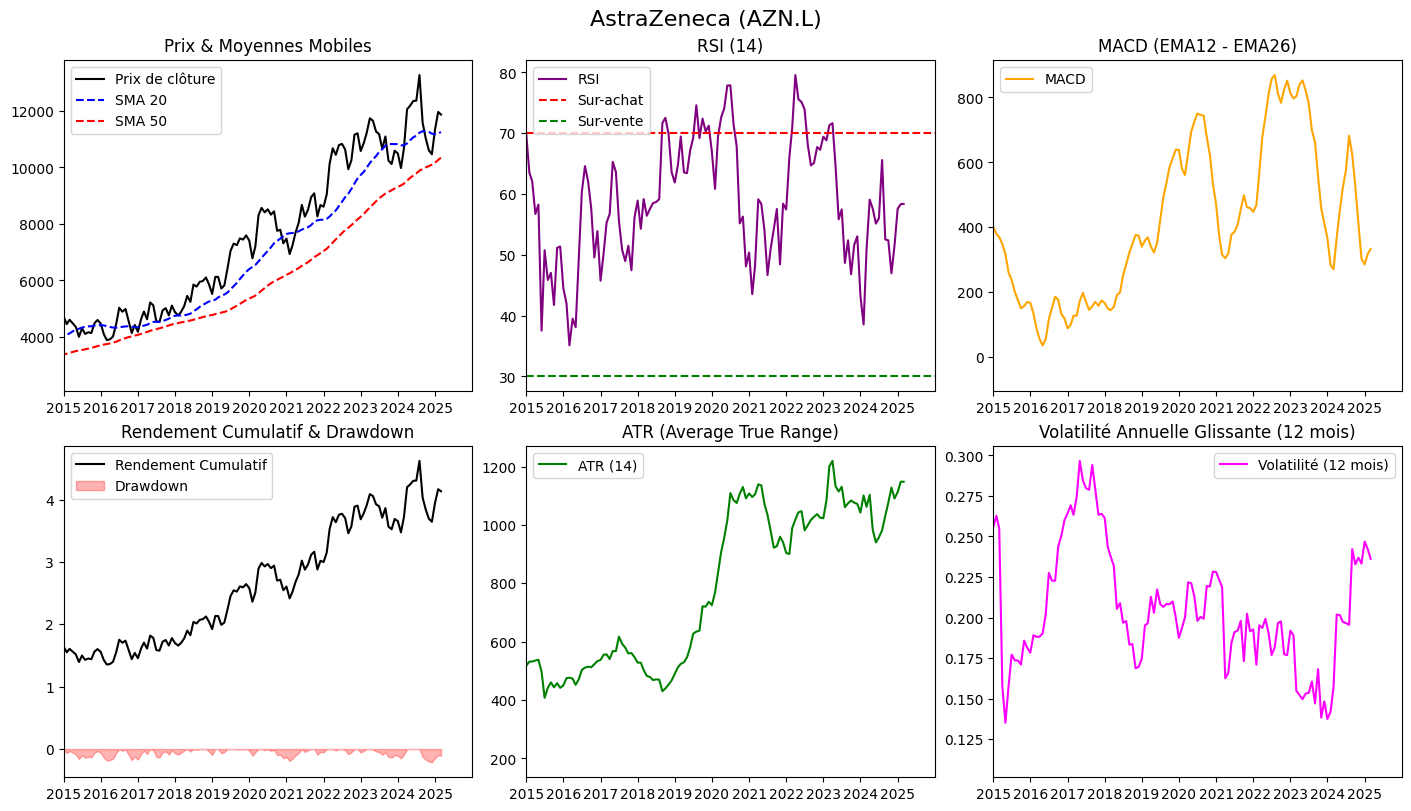

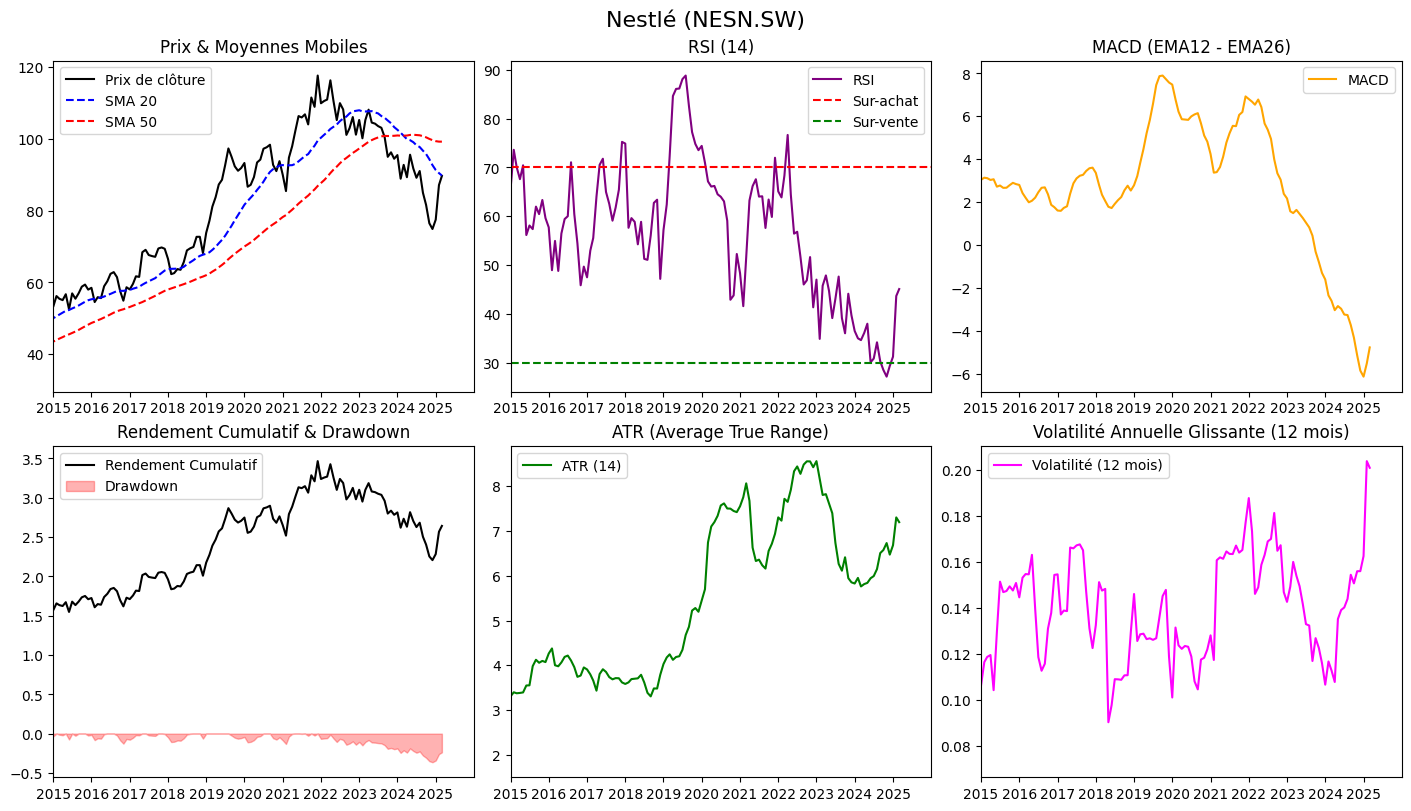

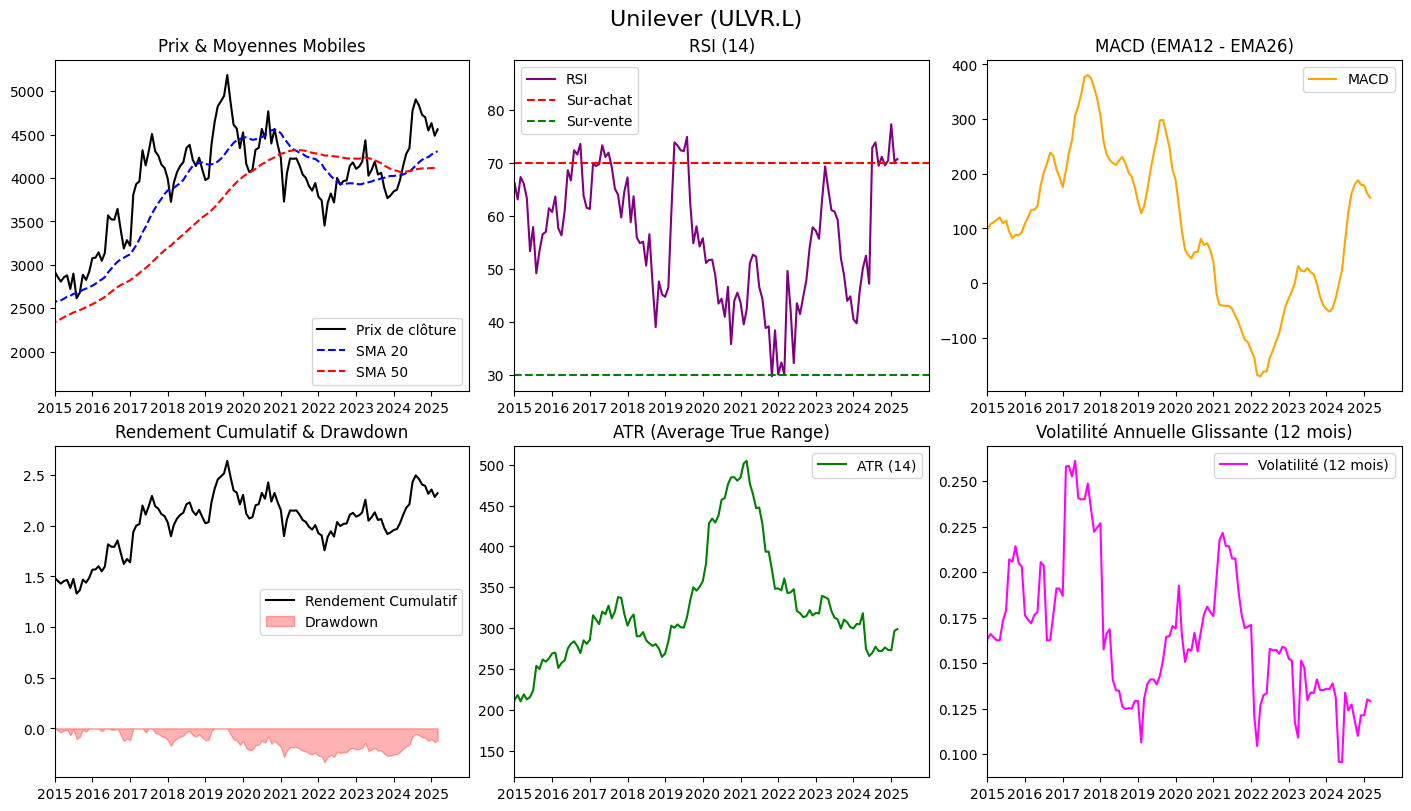

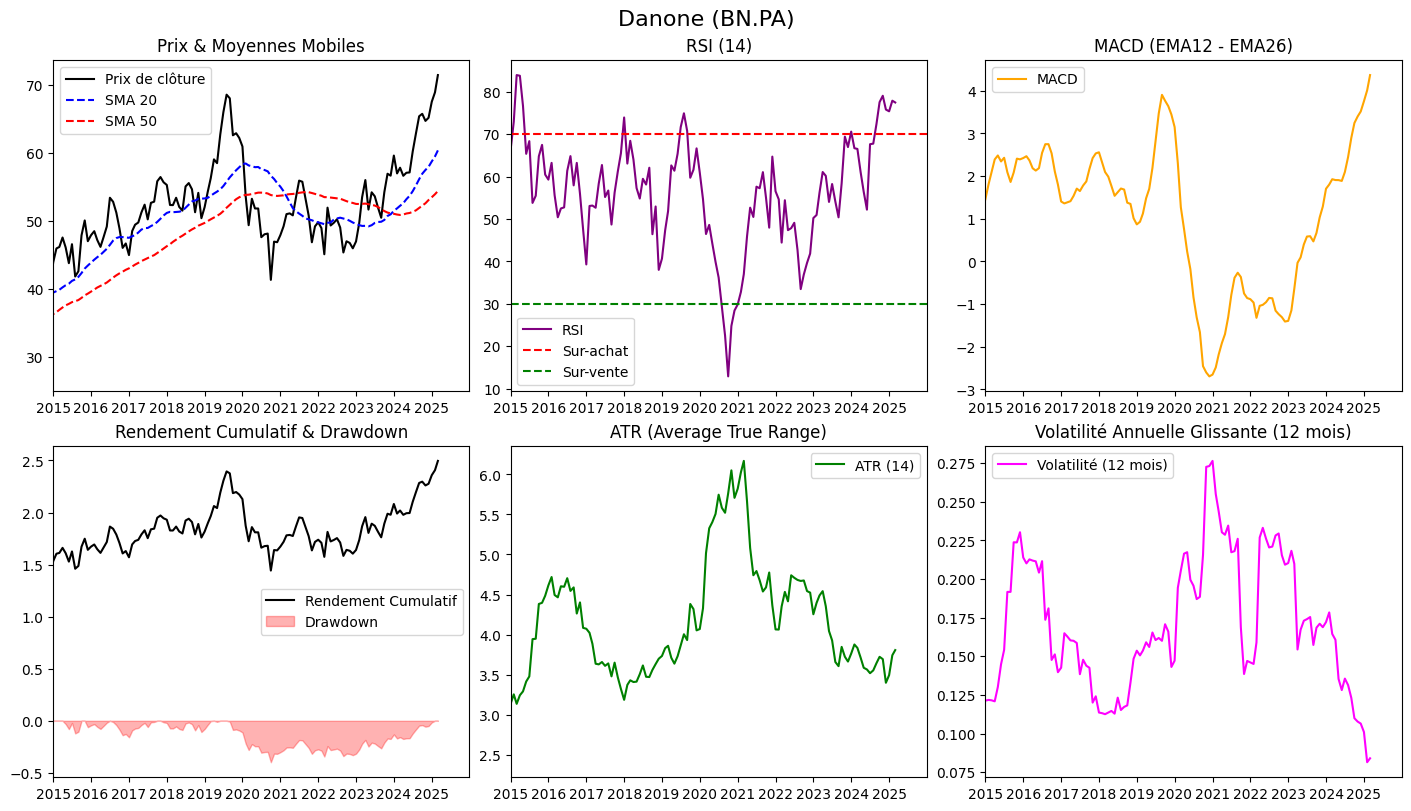

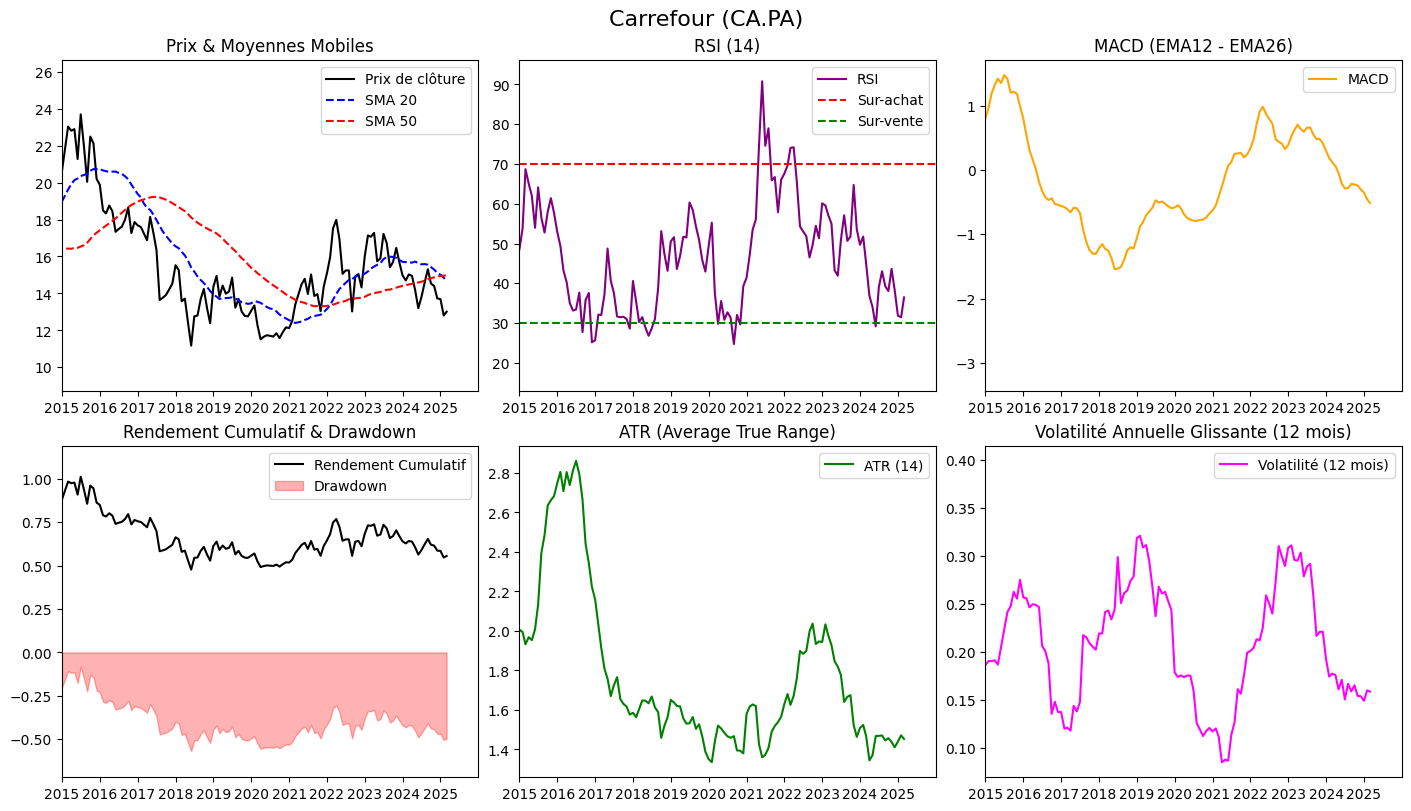

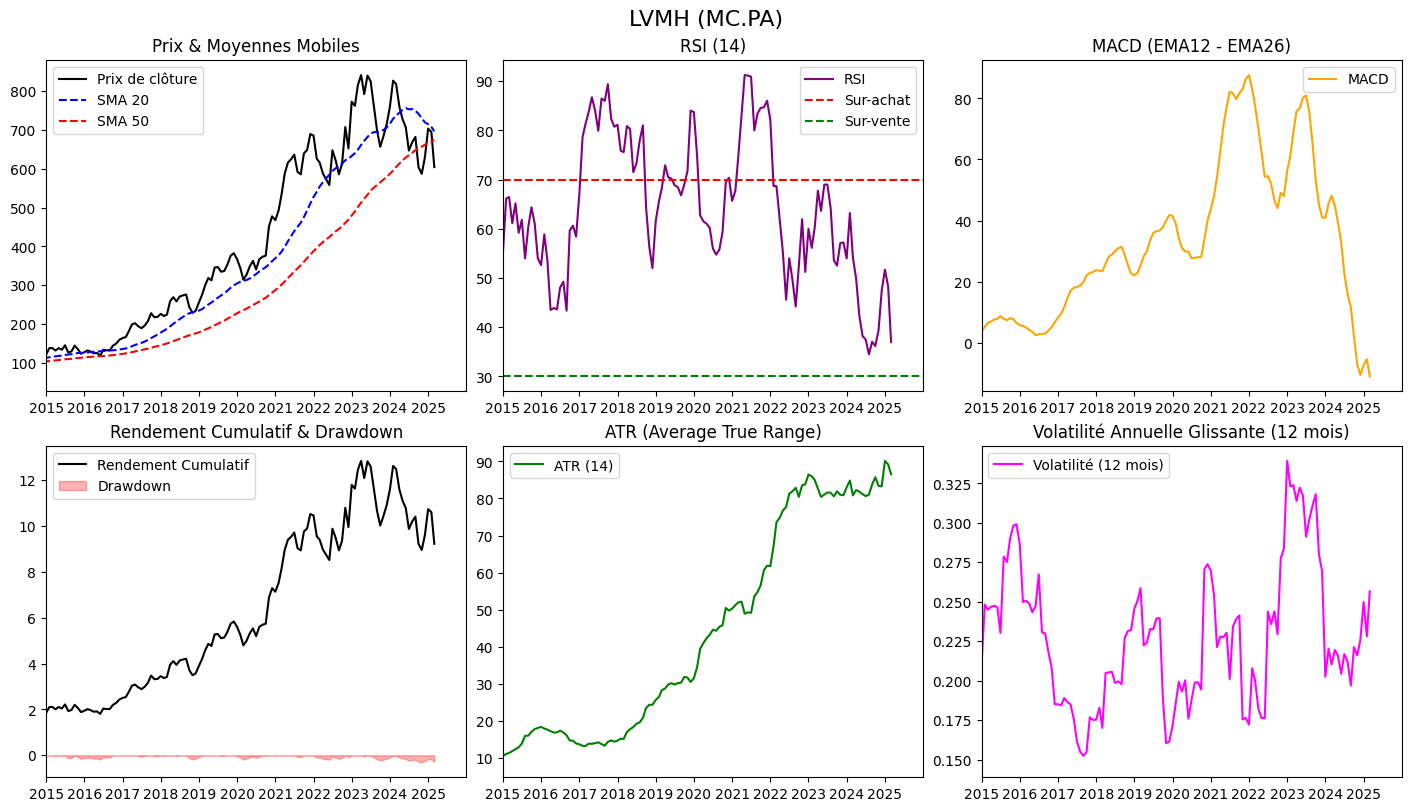

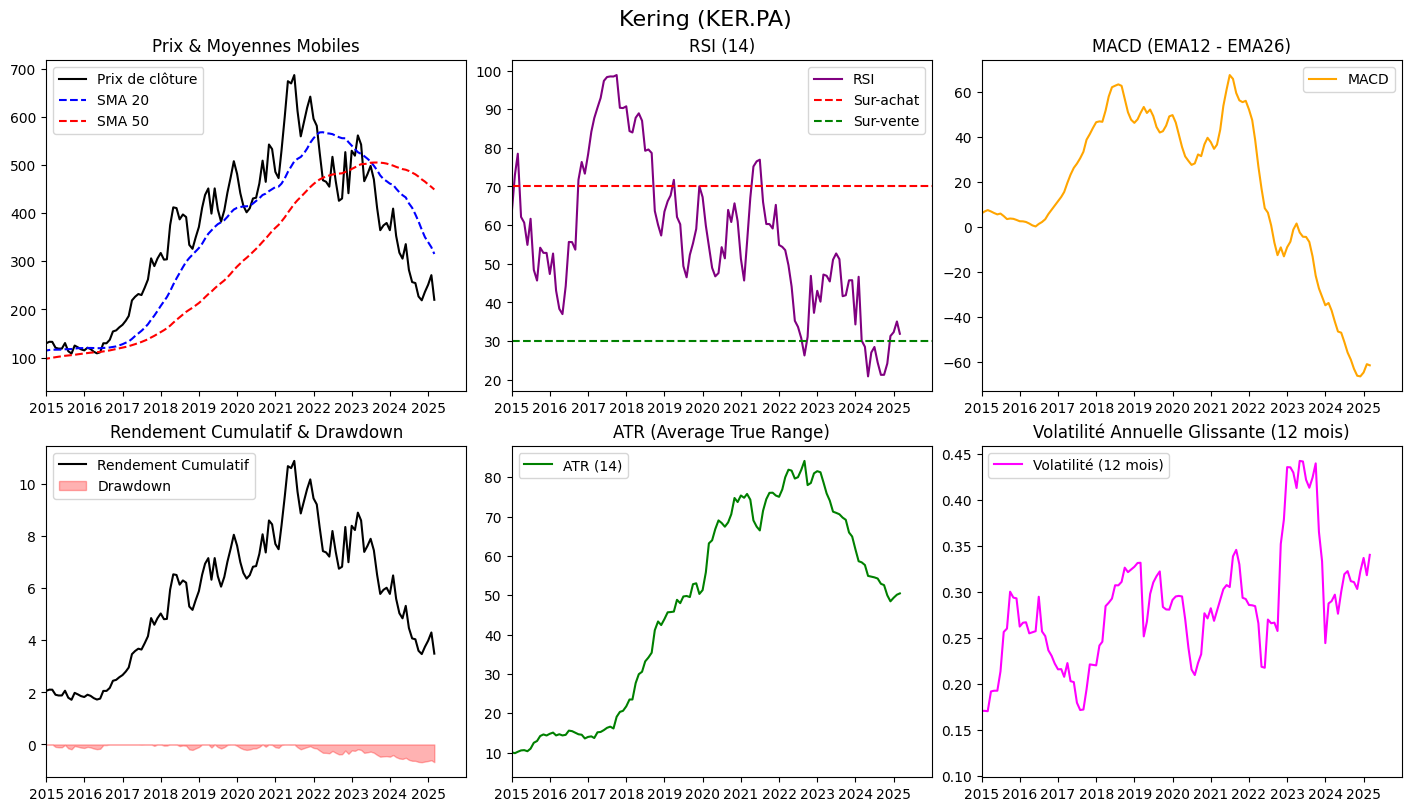

In [ ]:

# Fonctions de calcul des indicateurs

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_indicators(df):
    df['Return'] = df['Close'].pct_change()
    df['Rendement Cumulatif'] = (1 + df['Return']).cumprod()

    # Moyennes mobiles
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['SMA50'] = df['Close'].rolling(window=50).mean()

    # RSI
    df['RSI'] = compute_rsi(df['Close'], period=14)

    # MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']

    # ATR
    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift()),
        np.abs(df['Low'] - df['Close'].shift())
    ])
    df['ATR'] = df['TR'].rolling(window=14).mean()

    # Volatilité annuelle glissante (12 mois)
    df['Volatilite_12m'] = df['Return'].rolling(window=12).std() * np.sqrt(12)

    # Drawdown
    df['Cumulative Max'] = df['Rendement Cumulatif'].cummax()
    df['Drawdown'] = df['Rendement Cumulatif'] / df['Cumulative Max'] - 1

    # Statistiques (optionnel)
    indicateurs = {
        'Volatilité (std) sur toute la période': df['Return'].std(),
        'Drawdown Maximal': df['Drawdown'].min(),
        'Asymétrie (Skewness)': df['Return'].skew(),
        'Kurtosis': df['Return'].kurtosis()
    }

    return df, indicateurs

# Paramètres et dictionnaire

# Les listes et dictionnaires de tickers et libellés
tickers = [
    "ASML.AS", "SAP.DE", "IFX.DE", "STMPA.PA", "ERIC-B.ST",
    "SAN.PA", "NOVO-B.CO", "BAYN.DE", "ROG.SW", "AZN.L",
    "NESN.SW", "ULVR.L", "BN.PA", "CA.PA", "MC.PA", "KER.PA"
]

tickers_label = {
    "ASML.AS": "ASML Holding",
    "SAP.DE": "SAP",
    "IFX.DE": "Infineon Technologies",
    "STMPA.PA": "STMicroelectronics",
    "ERIC-B.ST": "Ericsson",
    "SAN.PA": "Sanofi",
    "NOVO-B.CO": "Novo Nordisk",
    "BAYN.DE": "Bayer",
    "ROG.SW": "Roche",
    "AZN.L": "AstraZeneca",
    "NESN.SW": "Nestlé",
    "ULVR.L": "Unilever",
    "BN.PA": "Danone",
    "CA.PA": "Carrefour",
    "MC.PA": "LVMH",
    "KER.PA": "Kering"
}

# Boucle sur les tickers du dictionnaire pour afficher les graphiques
for ticker in tickers:
    if ticker not in df_dict:
        print(f"Pas de données pour {ticker}")
        continue
    df = df_dict[ticker]
    if df.empty:
        continue

    # Calcul des indicateurs sur l'ensemble des données
    df_full, indicateurs = compute_indicators(df)


    date_start = pd.Timestamp('2015-01-01')
    date_end   = pd.Timestamp('2025-12-31')

    # Création d'une mosaïque de subplots en 2 lignes x 3 colonnes
    mosaic = """
    ABC
    DEF
    """
    fig, axes_dict = plt.subplot_mosaic(mosaic, figsize=(14, 8), constrained_layout=True)

    # Pour chaque axe, on trace les courbes à partir du df_full,
    # puis on fixe l'intervalle x pour n'afficher que la période 2015-2025.

    # A. Prix de clôture et Moyennes Mobiles
    axes_dict["A"].plot(df_full.index, df_full['Close'], label='Prix de clôture', color='black')
    axes_dict["A"].plot(df_full.index, df_full['SMA20'], label='SMA 20', color='blue', linestyle='--')
    axes_dict["A"].plot(df_full.index, df_full['SMA50'], label='SMA 50', color='red', linestyle='--')
    axes_dict["A"].set_title("Prix & Moyennes Mobiles")
    axes_dict["A"].legend()
    axes_dict["A"].set_xlim(date_start, date_end)

    # B. RSI
    axes_dict["B"].plot(df_full.index, df_full['RSI'], label='RSI', color='purple')
    axes_dict["B"].axhline(70, color='red', label="Sur-achat", linestyle='--')
    axes_dict["B"].axhline(30, color='green', label="Sur-vente", linestyle='--')
    axes_dict["B"].set_title("RSI (14)")
    axes_dict["B"].legend()
    axes_dict["B"].set_xlim(date_start, date_end)

    # C. MACD
    axes_dict["C"].plot(df_full.index, df_full['MACD'], label='MACD', color='orange')
    axes_dict["C"].set_title("MACD (EMA12 - EMA26)")
    axes_dict["C"].legend()
    axes_dict["C"].set_xlim(date_start, date_end)

    # D. Rendement Cumulatif & Drawdown
    axes_dict["D"].plot(df_full.index, df_full['Rendement Cumulatif'], label='Rendement Cumulatif', color='black')
    axes_dict["D"].fill_between(df_full.index, df_full['Drawdown'], 0, color='red', alpha=0.3, label='Drawdown')
    axes_dict["D"].set_title("Rendement Cumulatif & Drawdown")
    axes_dict["D"].legend()
    axes_dict["D"].set_xlim(date_start, date_end)

    # E. ATR
    axes_dict["E"].plot(df_full.index, df_full['ATR'], label='ATR (14)', color='green')
    axes_dict["E"].set_title("ATR (Average True Range)")
    axes_dict["E"].legend()
    axes_dict["E"].set_xlim(date_start, date_end)

    # F. Volatilité Annuelle Glissante (12 mois)
    axes_dict["F"].plot(df_full.index, df_full['Volatilite_12m'], label='Volatilité (12 mois)', color='magenta')
    axes_dict["F"].set_title("Volatilité Annuelle Glissante (12 mois)")
    axes_dict["F"].legend()
    axes_dict["F"].set_xlim(date_start, date_end)

    fig.suptitle(f"{tickers_label.get(ticker, ticker)} ({ticker})", fontsize=16)
    plt.show()


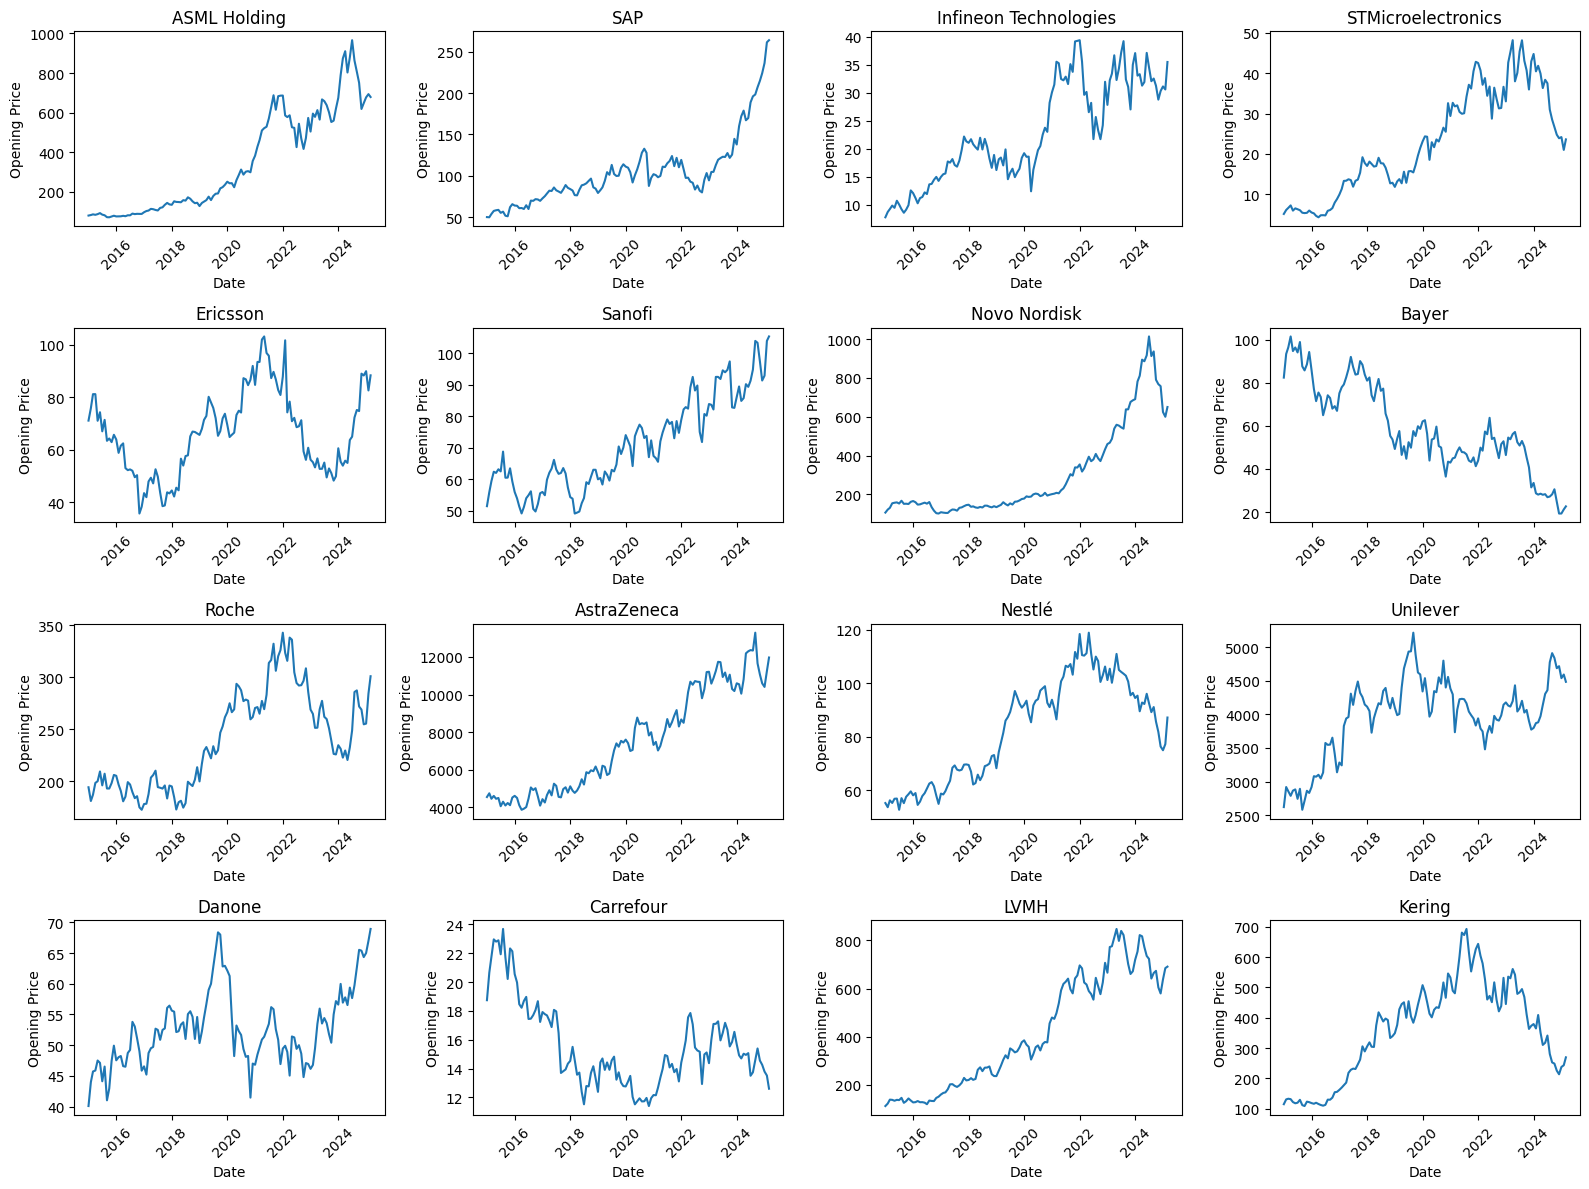

In [ ]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(4, 4, figure=fig)

# Itérer sur les clés du dictionnaire
for i, ticker in enumerate(data_dict.keys()):
    ax = fig.add_subplot(gs[i])
    ticker_data = data_dict[ticker]
    ax.plot(ticker_data.index, ticker_data['Open'])
    ax.set_title(tickers_label.get(ticker, ticker))
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Date")
    ax.set_ylabel("Opening Price")

plt.tight_layout()
plt.show()



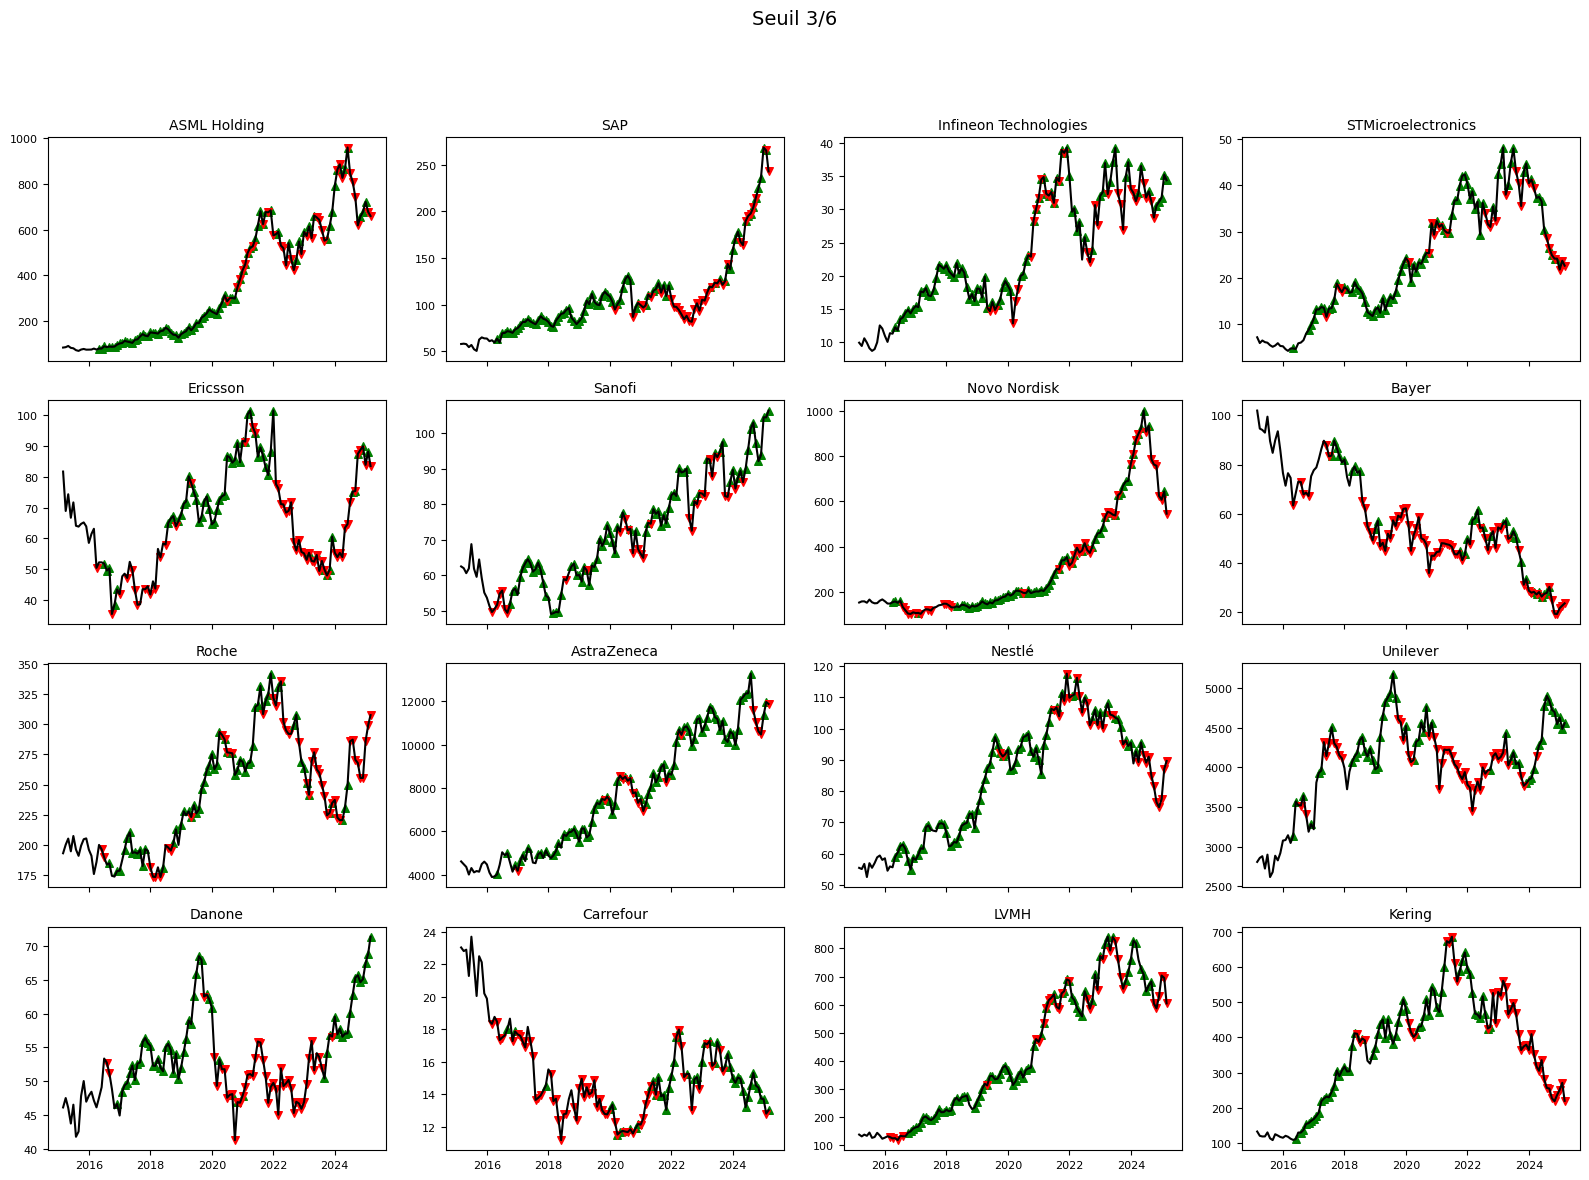

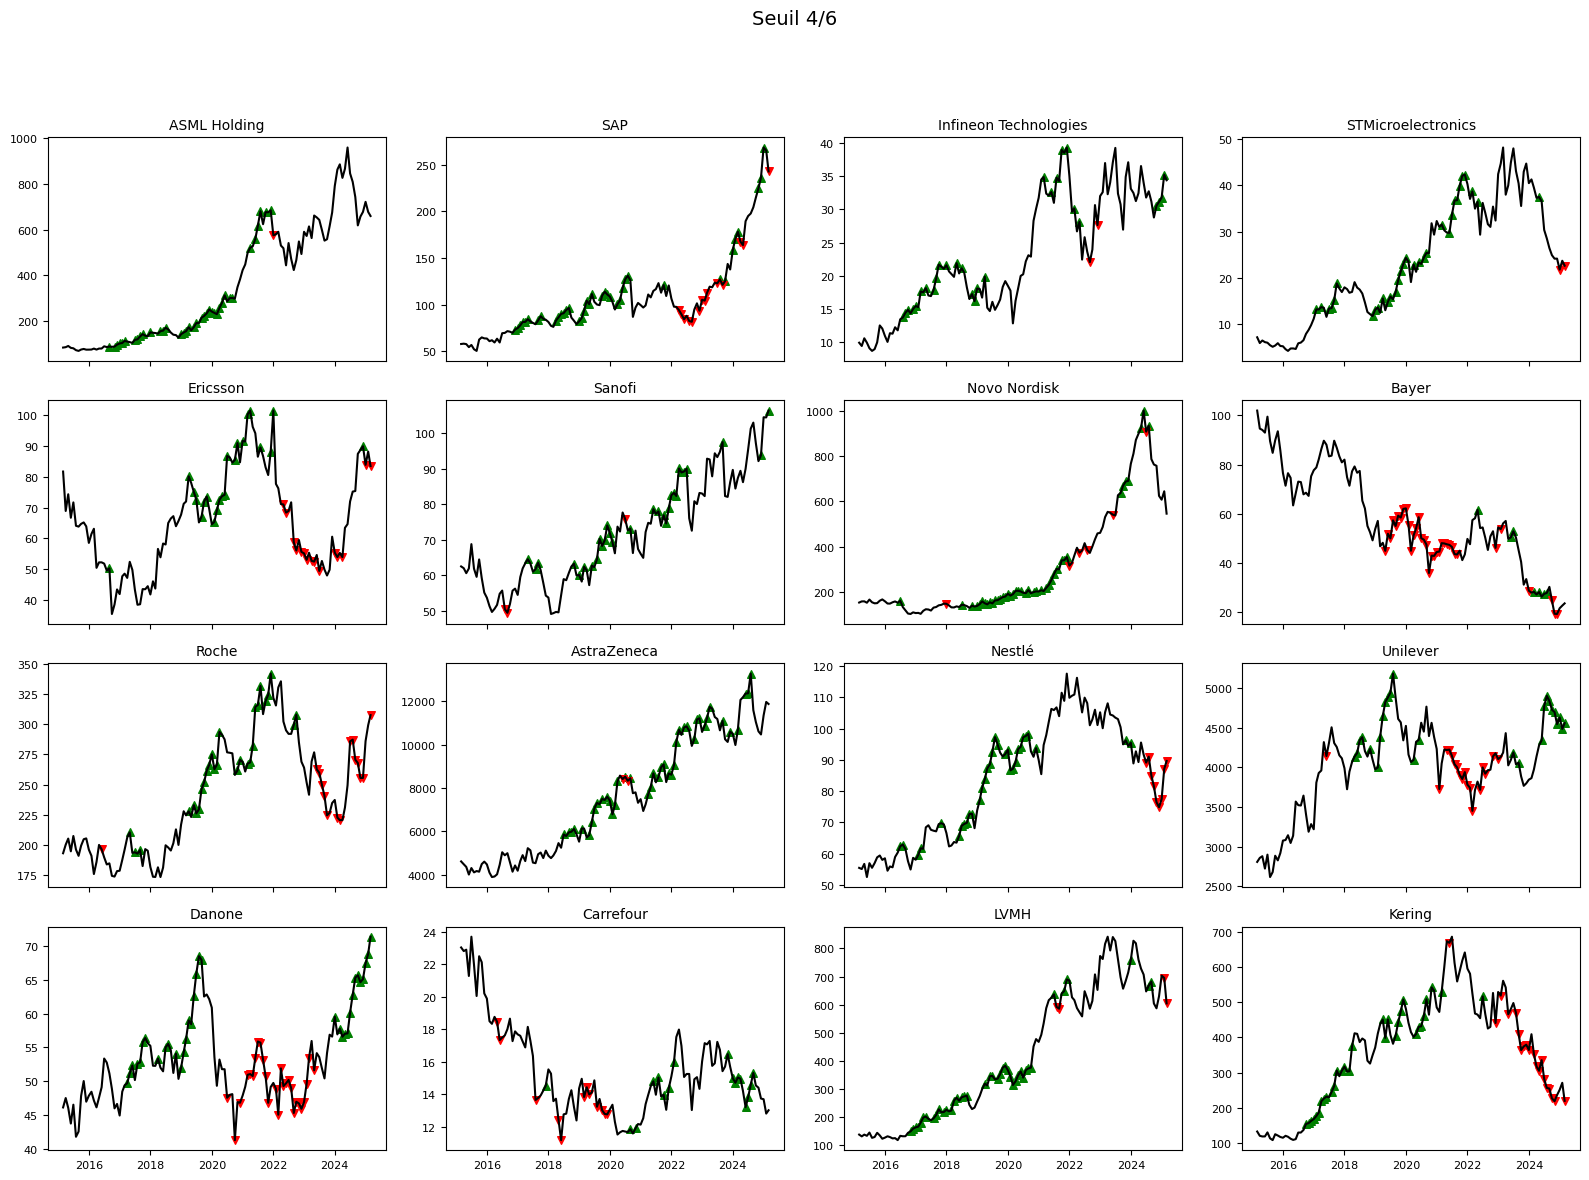

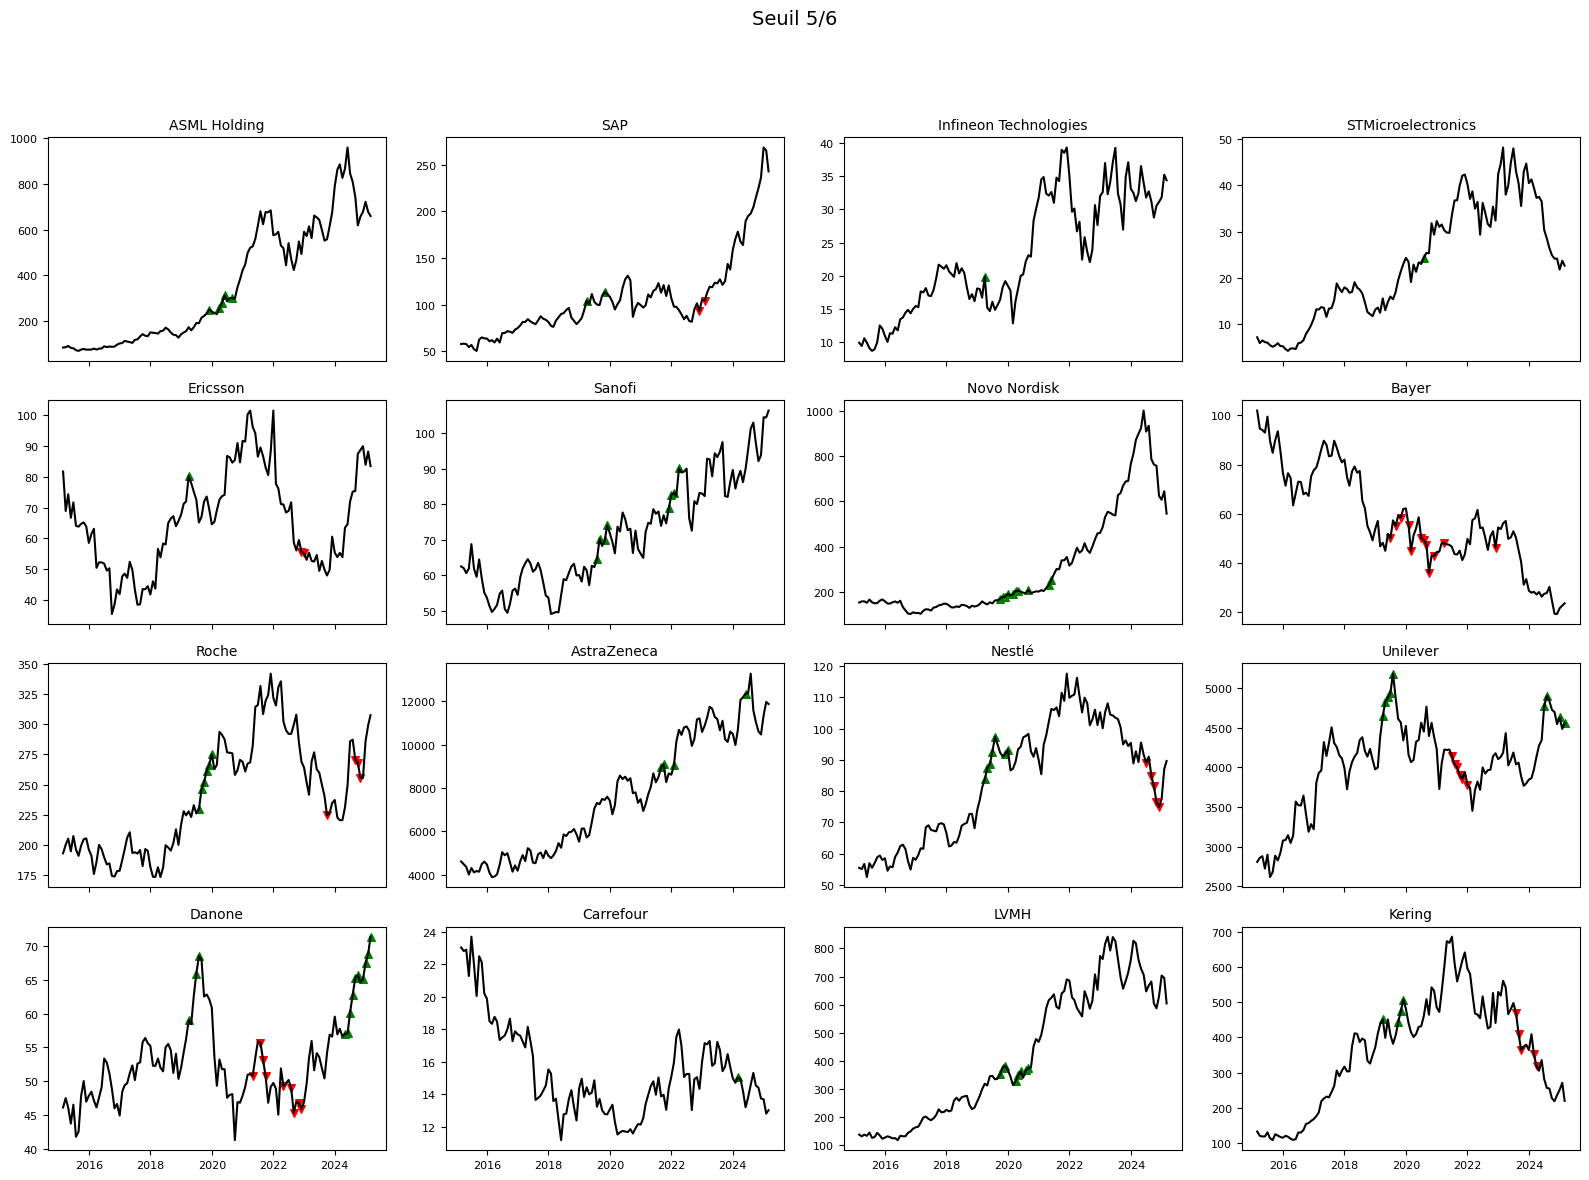

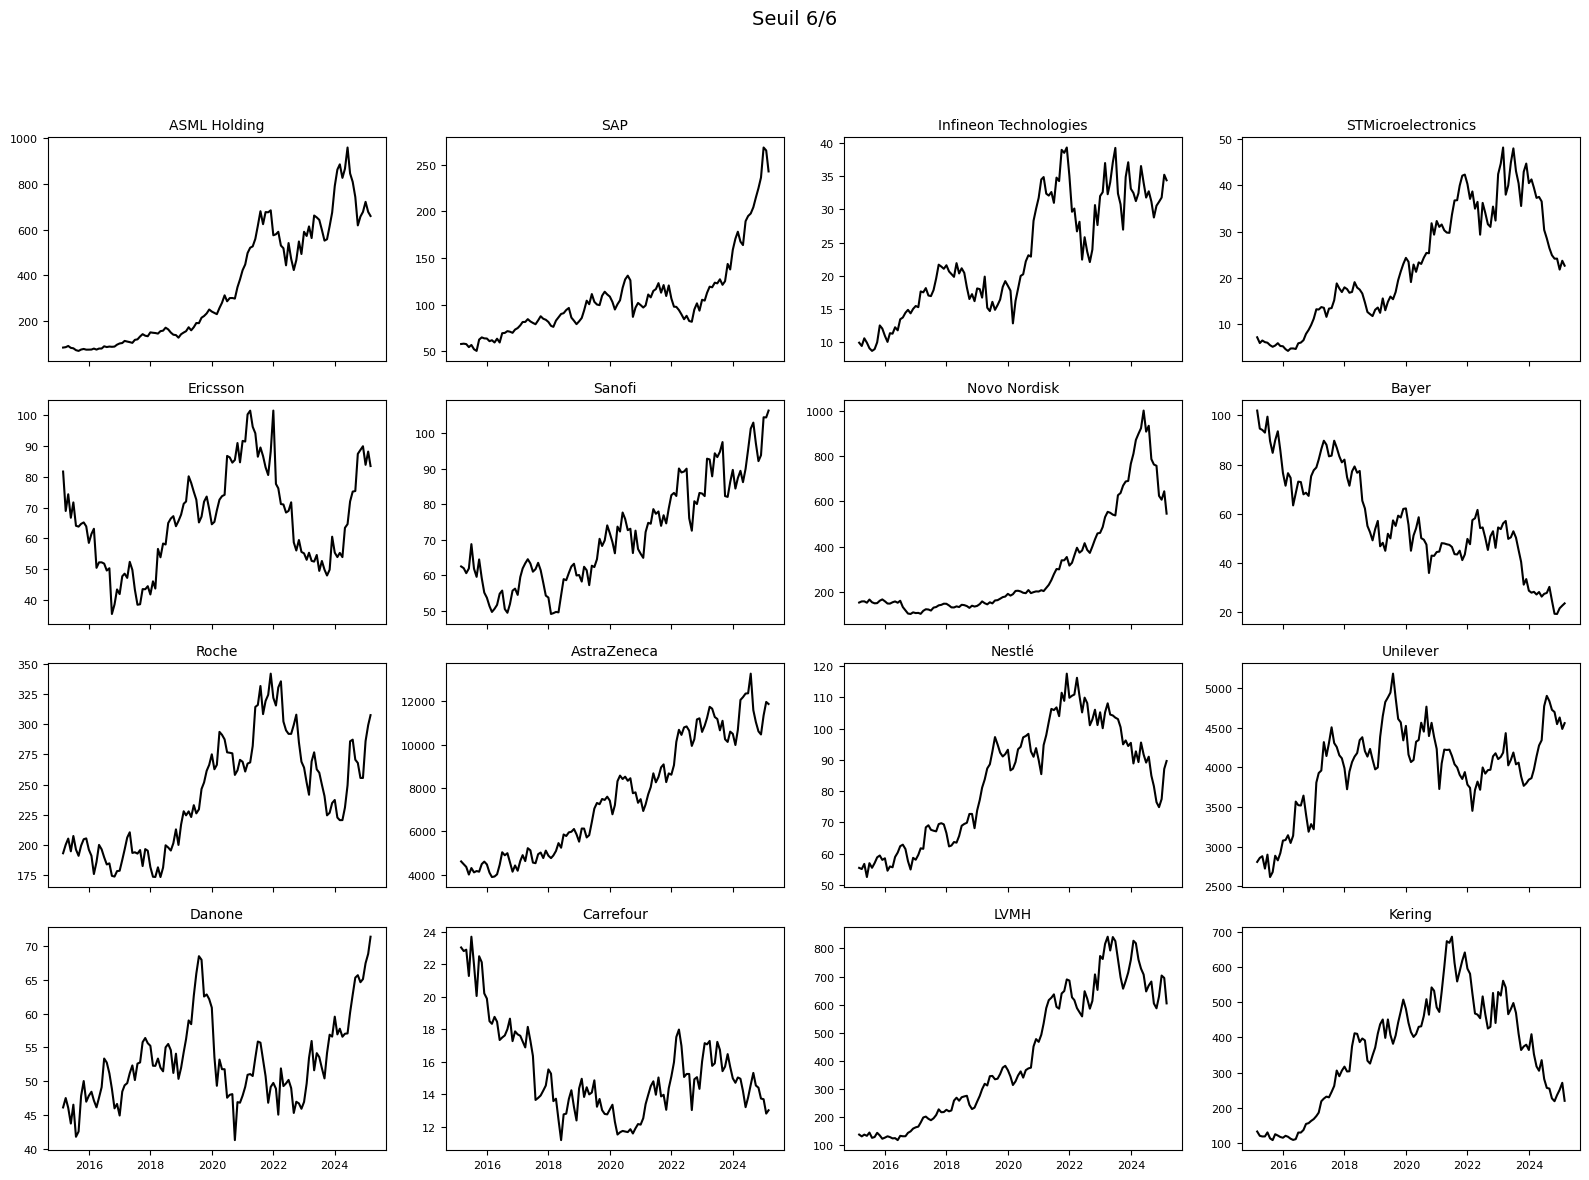

In [ ]:

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


# Liste des tickers et leurs libellés
tickers = [
    "ASML.AS", "SAP.DE", "IFX.DE", "STMPA.PA", "ERIC-B.ST",
    "SAN.PA", "NOVO-B.CO", "BAYN.DE", "ROG.SW", "AZN.L",
    "NESN.SW", "ULVR.L", "BN.PA", "CA.PA", "MC.PA", "KER.PA"
]
tickers_label = {
    "ASML.AS": "ASML Holding",
    "SAP.DE": "SAP",
    "IFX.DE": "Infineon Technologies",
    "STMPA.PA": "STMicroelectronics",
    "ERIC-B.ST": "Ericsson",
    "SAN.PA": "Sanofi",
    "NOVO-B.CO": "Novo Nordisk",
    "BAYN.DE": "Bayer",
    "ROG.SW": "Roche",
    "AZN.L": "AstraZeneca",
    "NESN.SW": "Nestlé",
    "ULVR.L": "Unilever",
    "BN.PA": "Danone",
    "CA.PA": "Carrefour",
    "MC.PA": "LVMH",
    "KER.PA": "Kering"
}

# Fonctions utilitaires et de calcul

# On définit une fonction qui permet d'extraire une valeur scalaire à partir d'un objet
# Si c'est une series, on prend le premier élément, sinon on retourne la valeur directement
def get_scalar(x):
    return x.iloc[0] if isinstance(x, pd.Series) else x

# On définit la fonction pour calculer le RSI
# On commence par calculer la différence entre les valeurs de la série
# on sépare les gains (valeurs positives) et les pertes (valeurs négatives transformées en positives)
# on calcule la moyenne glissante des gains et des pertes sur une période donnée
# On détermine le ratio RS et on calcule le RSI selon la formule standard
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# On définit une fonction pour calculer l'ensemble des indicateurs techniques à partir d'un DataFrame contenant les données boursières
def compute_indicators(df):
    # On calcule le rendement quotidien à partir des prix de clôture
    df['Return'] = df['Close'].pct_change()
    # On calcule le rendement cumulé pour voir l'évolution de l'investissement dans le temps
    df['Rendement Cumulatif'] = (1 + df['Return']).cumprod()
    # On calcule les moyennes mobiles simples sur 20 et 50 périodes
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    # On calcule le RSI sur la période de 14 jours.
    df['RSI'] = compute_rsi(df['Close'], period=14)
    # On calcule les moyennes mobiles exponentielles pour le calcul du MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    # On détermine le MACD qui est la différence entre les deux EMA
    df['MACD'] = df['EMA12'] - df['EMA26']
    # On calcule le True Range en prenant le maximum entre la différence haute-basse, et la différence absolue entre la haute ou la basse et la clôture précédente.
    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift()),
        np.abs(df['Low'] - df['Close'].shift())
    ])
    # On calcule l'ATR sur une fenêtre de 14 périodes
    df['ATR'] = df['TR'].rolling(window=14).mean()
    # On calcule une mesure de volatilité sur 12 périodes en annualisant l'écart-type des rendements
    df['Volatilite_12m'] = df['Return'].rolling(window=12).std() * np.sqrt(12)
    # On détermine la valeur cumulée maximale pour le calcul du drawdown
    df['Cumulative Max'] = df['Rendement Cumulatif'].cummax()
    # On calcule le drawdown comme le pourcentage de baisse par rapport au maximum cumulatif atteint
    df['Drawdown'] = df['Rendement Cumulatif'] / df['Cumulative Max'] - 1
    return df

# On définit la fonction pour générer un signal d'achat en fonction de différents indicateurs
# On compare les moyennes mobiles, le RSI, le MACD, l'évolution du rendement cumulé, l'ATR et la volatilité
# On compte le nombre de conditions favorables et on retourne True si ce nombre dépasse ou atteint le seuil
def buy_signal_threshold(prev, curr, median_atr, median_vol, threshold):
    conditions = {}
    # On vérifie que la moyenne mobile sur 20 période est supérieure à celle sur 50 périodes
    conditions['SMA'] = get_scalar(curr['SMA20']) > get_scalar(curr['SMA50'])
    # On vérifie que le RSI est dans une zone de survente (< 30)
    conditions['RSI'] = get_scalar(curr['RSI']) < 30
    # On vérifie que le MACD est positif
    conditions['MACD'] = get_scalar(curr['MACD']) > 0
    # On vérifie que le rendement cumulé est en hausse par rapport à la période précédente
    conditions['Cumulative'] = get_scalar(curr['Rendement Cumulatif']) > get_scalar(prev['Rendement Cumulatif'])
    # On s'assure que l'ATR est inférieur à la médiane (donc faible volatilité)
    conditions['ATR'] = get_scalar(curr['ATR']) < median_atr
    # On s'assure que la volatilité est inférieure à la médiane
    conditions['Volatility'] = get_scalar(curr['Volatilite_12m']) < median_vol
    valid_count = sum(conditions.values())
    return valid_count >= threshold

# De manière similaire, on définit la fonction pour générer un signal de vente.
# Ici, les conditions sont inversées : on attend que la SMA20 soit inférieure à la SMA50, le RSI soit en zone de surachat (> 70), etc.
def sell_signal_threshold(prev, curr, median_atr, median_vol, threshold):
    conditions = {}
    conditions['SMA'] = get_scalar(curr['SMA20']) < get_scalar(curr['SMA50'])
    conditions['RSI'] = get_scalar(curr['RSI']) > 70
    conditions['MACD'] = get_scalar(curr['MACD']) < 0
    conditions['Cumulative'] = get_scalar(curr['Rendement Cumulatif']) < get_scalar(prev['Rendement Cumulatif'])
    conditions['ATR'] = get_scalar(curr['ATR']) > median_atr
    conditions['Volatility'] = get_scalar(curr['Volatilite_12m']) > median_vol
    valid_count = sum(conditions.values())
    return valid_count >= threshold

# On simule les trades en parcourant le DataFrame chronologiquement
# On démarre sans position, et à chaque pas, on vérifie les signaux d'achat et de vente
# Si on détecte un signal d'achat, on enregistre le prix d'entrée et on se met en position
# Si on détecte un signal de vente et que l'on est en position, on enregistre le prix de sortie et on calcule le rendement du trade
# En fin de période, si on est toujours en position, on clôture la position en utilisant le dernier prix de clôture
def simulate_trades(df, threshold, median_atr, median_vol):
    in_position = False
    entry_price = None
    trade_returns = []
    # On parcourt le DataFrame à partir de la deuxième ligne pour comparer avec la ligne précédente
    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]
        # Si on n'est pas en position et que les conditions d'achat sont remplies, on ouvre une position
        if not in_position and buy_signal_threshold(prev, curr, median_atr, median_vol, threshold):
            entry_price = get_scalar(curr['Close'])
            in_position = True
        # Si on est en position et que les conditions de vente sont remplies, on ferme la position et on calcule le rendement
        elif in_position and sell_signal_threshold(prev, curr, median_atr, median_vol, threshold):
            exit_price = get_scalar(curr['Close'])
            trade_return = exit_price / entry_price - 1
            trade_returns.append(trade_return)
            in_position = False
            entry_price = None
    # Si on est encore en position à la fin, on clôture la dernière position avec le dernier prix
    if in_position:
        exit_price = get_scalar(df.iloc[-1]['Close'])
        trade_return = exit_price / entry_price - 1
        trade_returns.append(trade_return)
    return trade_returns

# Enfin, on définit une fonction pour calculer quelques statistiques de base sur les trades réalisés
# On calcule le nombre de trades, le rendement moyen, la médiane et le rendement cumulé de l'ensemble des trades
def compute_trade_stats(trade_returns):
    if len(trade_returns) == 0:
        return {"n_trades": 0}
    stats = {}
    stats["n_trades"] = len(trade_returns)
    stats["avg_return"] = np.mean(trade_returns)
    stats["median_return"] = np.median(trade_returns)
    stats["cum_return"] = np.prod(1 + np.array(trade_returns)) - 1
    return stats


# Liste des seuils à tester
thresholds = [3, 4, 5, 6]

# Organisation des graphiques dans une grille (ici 4 colonnes)
n_cols = 4
n_tickers = len(tickers)
n_rows_grid = math.ceil(n_tickers / n_cols)

for thr in thresholds:
    fig, axes = plt.subplots(nrows=n_rows_grid, ncols=n_cols, figsize=(4*n_cols, 3*n_rows_grid), sharex=True)
    fig.suptitle(f"Seuil {thr}/6", fontsize=14)

    # Conversion en tableau 1D pour faciliter l'itération
    if n_rows_grid * n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, ticker in enumerate(tickers):
        ax = axes[idx]
        # Récupérer le DataFrame depuis df_dict
        df = df_dict.get(ticker)
        if df is None or df.empty:
            ax.set_title(f"{ticker}\n(No data)")
            continue

        # Filtrer pour ne conserver que les 10 dernières années
        df = df[df.index >= df.index.max() - pd.DateOffset(years=10)]
        # Calcul des indicateurs techniques
        df = compute_indicators(df)
        median_atr = df['ATR'].median()
        median_vol = df['Volatilite_12m'].median()

        buy_dates = []
        buy_prices = []
        sell_dates = []
        sell_prices = []

        # Itérer sur les données pour détecter les signaux
        for i in range(1, len(df)):
            prev = df.iloc[i-1]
            curr = df.iloc[i]
            if buy_signal_threshold(prev, curr, median_atr, median_vol, thr):
                buy_dates.append(curr.name)
                buy_prices.append(curr['Close'])
            if sell_signal_threshold(prev, curr, median_atr, median_vol, thr):
                sell_dates.append(curr.name)
                sell_prices.append(curr['Close'])

        ax.plot(df.index, df['Close'], color='black')
        if buy_dates:
            ax.scatter(buy_dates, buy_prices, marker='^', color='green', s=30)
        if sell_dates:
            ax.scatter(sell_dates, sell_prices, marker='v', color='red', s=30)
        ax.set_title(tickers_label.get(ticker, ticker), fontsize=10)
        ax.tick_params(axis='both', labelsize=8)

    # Masquer les axes en trop s'il y en a
    for j in range(idx+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


In [ ]:

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


#Fonctions de base

def get_scalar(x):
    return x.iloc[0] if isinstance(x, pd.Series) else x

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_indicators(df):
    df['Return'] = df['Close'].pct_change()
    df['Rendement Cumulatif'] = (1 + df['Return']).cumprod()
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    df['RSI'] = compute_rsi(df['Close'], period=14)
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift()),
        np.abs(df['Low'] - df['Close'].shift())
    ])
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df['Volatilite_12m'] = df['Return'].rolling(window=12).std() * np.sqrt(12)
    df['Cumulative Max'] = df['Rendement Cumulatif'].cummax()
    df['Drawdown'] = df['Rendement Cumulatif'] / df['Cumulative Max'] - 1
    return df

# Fonctions de détection avec seuil sur 6 conditions
def buy_signal_threshold(prev, curr, median_atr, median_vol, threshold):
    conditions = {}
    conditions['SMA'] = get_scalar(curr['SMA20']) > get_scalar(curr['SMA50'])
    conditions['RSI'] = get_scalar(curr['RSI']) < 30
    conditions['MACD'] = get_scalar(curr['MACD']) > 0
    conditions['Cumulative'] = get_scalar(curr['Rendement Cumulatif']) > get_scalar(prev['Rendement Cumulatif'])
    conditions['ATR'] = get_scalar(curr['ATR']) < median_atr
    conditions['Volatility'] = get_scalar(curr['Volatilite_12m']) < median_vol
    valid_count = sum(conditions.values())
    return valid_count >= threshold

def sell_signal_threshold(prev, curr, median_atr, median_vol, threshold):
    conditions = {}
    conditions['SMA'] = get_scalar(curr['SMA20']) < get_scalar(curr['SMA50'])
    conditions['RSI'] = get_scalar(curr['RSI']) > 70
    conditions['MACD'] = get_scalar(curr['MACD']) < 0
    conditions['Cumulative'] = get_scalar(curr['Rendement Cumulatif']) < get_scalar(prev['Rendement Cumulatif'])
    conditions['ATR'] = get_scalar(curr['ATR']) > median_atr
    conditions['Volatility'] = get_scalar(curr['Volatilite_12m']) > median_vol
    valid_count = sum(conditions.values())
    return valid_count >= threshold

# Simulation des trades et calcul des rendements

def simulate_trades(df, threshold, median_atr, median_vol):

      #- Si le signal d'achat est déclenché et qu'on n'est pas en position, on entre au prix de clôture
      #- Si le signal de vente  est déclenché et qu'on est en position, on sort au prix de clôture


    in_position = False
    entry_price = None
    trade_returns = []

    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]
        if not in_position and buy_signal_threshold(prev, curr, median_atr, median_vol, threshold):
            entry_price = get_scalar(curr['Close'])
            in_position = True
        elif in_position and sell_signal_threshold(prev, curr, median_atr, median_vol, threshold):
            exit_price = get_scalar(curr['Close'])
            trade_return = exit_price / entry_price - 1
            trade_returns.append(trade_return)
            in_position = False
            entry_price = None
    if in_position:
        exit_price = get_scalar(df.iloc[-1]['Close'])
        trade_return = exit_price / entry_price - 1
        trade_returns.append(trade_return)
    return trade_returns

def compute_trade_stats(trade_returns):
    if len(trade_returns) == 0:
        return {"n_trades": 0}
    stats = {}
    stats["n_trades"] = len(trade_returns)
    stats["avg_return"] = np.mean(trade_returns)
    stats["median_return"] = np.median(trade_returns)
    stats["cum_return"] = np.prod(1 + np.array(trade_returns)) - 1
    return stats

# Liste des seuils à tester
thresholds = [3, 4, 5, 6]

# Liste des tickers et leurs libellés (doivent correspondre aux clés de df_dict)
tickers = [
    "ASML.AS", "SAP.DE", "IFX.DE", "STMPA.PA", "ERIC-B.ST",
    "SAN.PA", "NOVO-B.CO", "BAYN.DE", "ROG.SW", "AZN.L",
    "NESN.SW", "ULVR.L", "BN.PA", "CA.PA", "MC.PA", "KER.PA"
]
tickers_label = {
    "ASML.AS": "ASML Holding",
    "SAP.DE": "SAP",
    "IFX.DE": "Infineon Technologies",
    "STMPA.PA": "STMicroelectronics",
    "ERIC-B.ST": "Ericsson",
    "SAN.PA": "Sanofi",
    "NOVO-B.CO": "Novo Nordisk",
    "BAYN.DE": "Bayer",
    "ROG.SW": "Roche",
    "AZN.L": "AstraZeneca",
    "NESN.SW": "Nestlé",
    "ULVR.L": "Unilever",
    "BN.PA": "Danone",
    "CA.PA": "Carrefour",
    "MC.PA": "LVMH",
    "KER.PA": "Kering"
}

# Dictionnaire pour stocker les résultats
results = {}

# Utilisation de df_dict pour éviter de retélécharger les données
for ticker in tickers:
    df = df_dict.get(ticker)
    if df is None or df.empty:
        continue
    # Conserver uniquement les 10 dernières années
    df = df[df.index >= df.index.max() - pd.DateOffset(years=10)]
    # Calcul des indicateurs techniques
    df = compute_indicators(df)
    # Calcul des médianes pour ATR et Volatilité sur la période
    median_atr = df['ATR'].median()
    median_vol = df['Volatilite_12m'].median()
    results[ticker] = {}
    for thr in thresholds:
        trade_returns = simulate_trades(df, thr, median_atr, median_vol)
        stats = compute_trade_stats(trade_returns)
        results[ticker][thr] = stats

# Affichage final des statistiques par ticker et par seuil
print("Statistiques de rendement par ticker et par seuil (nombre de conditions validées sur 6) :\n")
for ticker, stats_by_thr in results.items():
    print(f"Ticker: {ticker} - {tickers_label.get(ticker, ticker)}")
    for thr in thresholds:
        stats = stats_by_thr.get(thr, {})
        if stats.get("n_trades", 0) == 0:
            print(f"  Seuil {thr}/6: Aucun trade")
        else:
            print(f"  Seuil {thr}/6: {stats['n_trades']} trades, moyenne = {stats['avg_return']*100:.2f}%, médiane = {stats['median_return']*100:.2f}%, cumulatif = {stats['cum_return']*100:.2f}%")
    print("")


Statistiques de rendement par ticker et par seuil (nombre de conditions validées sur 6) :

Ticker: ASML.AS - ASML Holding
  Seuil 3/6: 18 trades, moyenne = 17.80%, médiane = 2.09%, cumulatif = 478.76%
  Seuil 4/6: 1 trades, moyenne = 538.61%, médiane = 538.61%, cumulatif = 538.61%
  Seuil 5/6: 1 trades, moyenne = 162.02%, médiane = 162.02%, cumulatif = 162.02%
  Seuil 6/6: Aucun trade

Ticker: SAP.DE - SAP
  Seuil 3/6: 14 trades, moyenne = 6.73%, médiane = 2.83%, cumulatif = 116.19%
  Seuil 4/6: 4 trades, moyenne = 16.44%, médiane = 18.26%, cumulatif = 77.18%
  Seuil 5/6: 1 trades, moyenne = -10.25%, médiane = -10.25%, cumulatif = -10.25%
  Seuil 6/6: Aucun trade

Ticker: IFX.DE - Infineon Technologies
  Seuil 3/6: 18 trades, moyenne = 0.14%, médiane = -1.32%, cumulatif = -16.97%
  Seuil 4/6: 2 trades, moyenne = 36.53%, médiane = 36.53%, cumulatif = 80.64%
  Seuil 5/6: 1 trades, moyenne = 72.77%, médiane = 72.77%, cumulatif = 72.77%
  Seuil 6/6: Aucun trade

Ticker: STMPA.PA - STMicroe

In [ ]:
def get_scalar(x):
    return x.iloc[0] if isinstance(x, pd.Series) else x

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_indicators(df):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['Rendement Cumulatif'] = (1 + df['Return']).cumprod()
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    df['RSI'] = compute_rsi(df['Close'], period=14)
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift()),
        np.abs(df['Low'] - df['Close'].shift())
    ])
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df['Volatilite_12m'] = df['Return'].rolling(window=12).std() * np.sqrt(12)
    df['Cumulative Max'] = df['Rendement Cumulatif'].cummax()
    df['Drawdown'] = df['Rendement Cumulatif'] / df['Cumulative Max'] - 1
    return df

def buy_signal_threshold(prev, curr, median_atr, median_vol, threshold):
    conditions = {
        'SMA': get_scalar(curr['SMA20']) > get_scalar(curr['SMA50']),
        'RSI': get_scalar(curr['RSI']) < 30,
        'MACD': get_scalar(curr['MACD']) > 0,
        'Cumulative': get_scalar(curr['Rendement Cumulatif']) > get_scalar(prev['Rendement Cumulatif']),
        'ATR': get_scalar(curr['ATR']) < median_atr,
        'Volatility': get_scalar(curr['Volatilite_12m']) < median_vol
    }
    return sum(conditions.values()) >= threshold

def sell_signal_threshold(prev, curr, median_atr, median_vol, threshold):
    conditions = {
        'SMA': get_scalar(curr['SMA20']) < get_scalar(curr['SMA50']),
        'RSI': get_scalar(curr['RSI']) > 70,
        'MACD': get_scalar(curr['MACD']) < 0,
        'Cumulative': get_scalar(curr['Rendement Cumulatif']) < get_scalar(prev['Rendement Cumulatif']),
        'ATR': get_scalar(curr['ATR']) > median_atr,
        'Volatility': get_scalar(curr['Volatilite_12m']) > median_vol
    }
    return sum(conditions.values()) >= threshold

# Recalculer tous les signaux et résultats pour df_all
all_results = []

for ticker, df in df_dict.items():
    if df is None or df.empty:
        continue
    df = df[df.index >= df.index.max() - pd.DateOffset(years=10)]
    df = compute_indicators(df)
    median_atr = df['ATR'].median()
    median_vol = df['Volatilite_12m'].median()

    for thr in [3, 4, 5, 6]:
        in_position = False
        entry_price = None
        entry_date = None
        for i in range(1, len(df)):
            prev = df.iloc[i - 1]
            curr = df.iloc[i]
            if not in_position and buy_signal_threshold(prev, curr, median_atr, median_vol, thr):
                entry_price = get_scalar(curr['Close'])
                entry_date = curr.name
                in_position = True
            elif in_position and sell_signal_threshold(prev, curr, median_atr, median_vol, thr):
                exit_price = get_scalar(curr['Close'])
                exit_date = curr.name
                trade_return = exit_price / entry_price - 1
                trend = 'bull' if curr['Rendement Cumulatif'] > 1 else 'bear'
                all_results.append({
                    'ticker': ticker,
                    'seuil': thr,
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'ret': trade_return,
                    'trend': trend,
                    'trend_encoded': 1 if trend == 'bull' else 0
                })
                in_position = False
                entry_price = None

df_all = pd.DataFrame(all_results)

print(all_results[""])


    ticker  seuil entry_date  exit_date       ret trend  trend_encoded
0  ASML.AS      3 2016-05-01 2020-07-01  2.530758  bull              1
1  ASML.AS      3 2020-08-01 2020-11-01  0.157652  bull              1
2  ASML.AS      3 2020-12-01 2021-01-01  0.105396  bull              1
3  ASML.AS      3 2021-02-01 2021-03-01  0.110991  bull              1
4  ASML.AS      3 2021-04-01 2021-05-01  0.011086  bull              1


La stratégie semble donc mieux marcher lorsque l'actif est sur une phase haussière, nous allons donc prendre ça en compte dans notre allocation

De plus elle semble également plus perdormante quand on a un seuil à 4/6


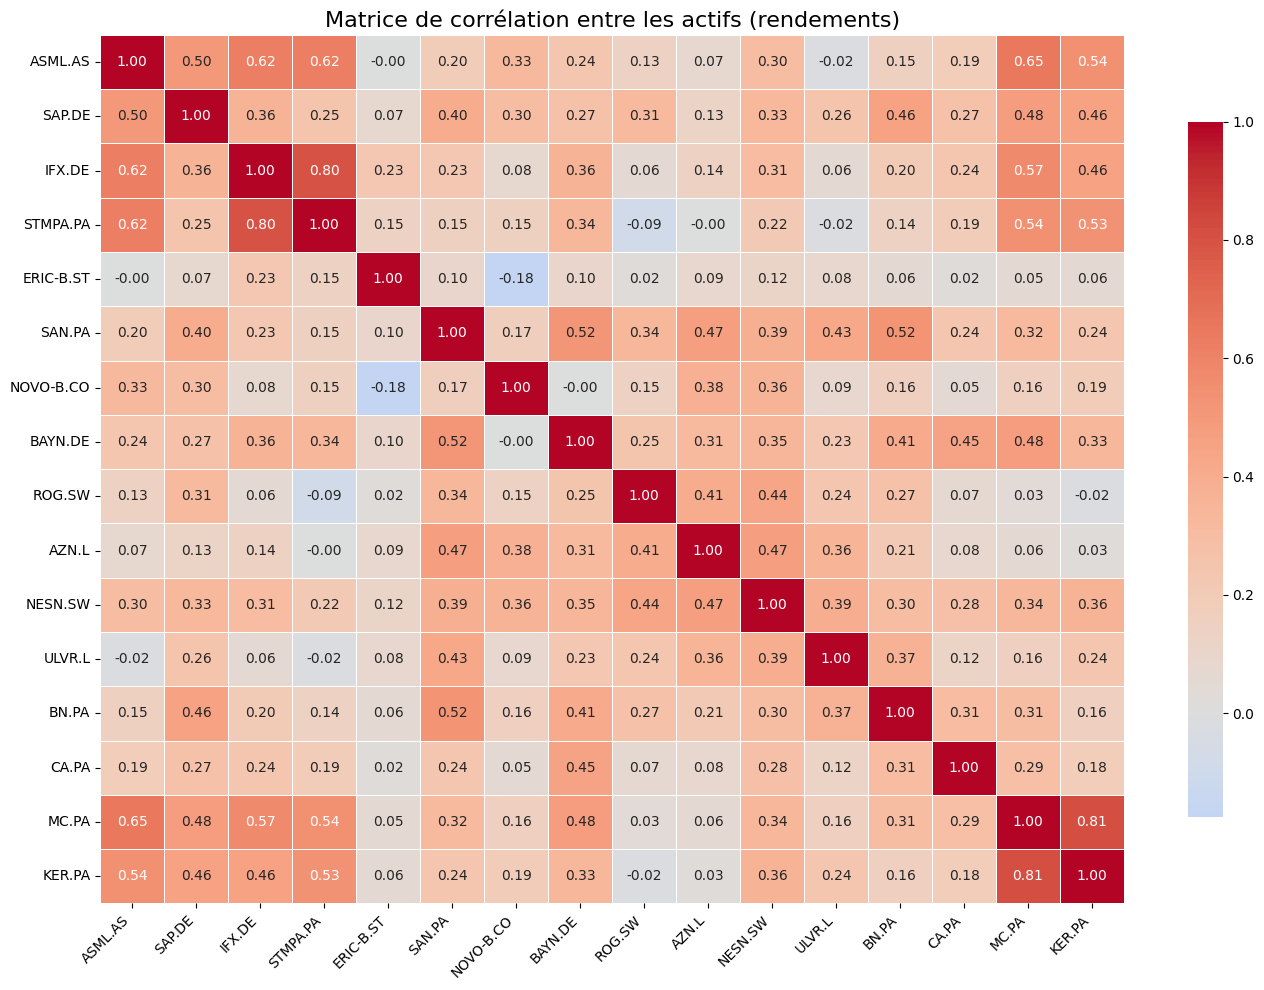

In [ ]:
import pandas as pd
import numpy as np
import os

data_dir = "/content/drive/MyDrive/Colab Notebooks"
returns_dict = {}

for file in os.listdir(data_dir):
    if file.startswith("data_") and file.endswith(".csv"):
        ticker = file.replace("data_", "").replace(".csv", "")
        path = os.path.join(data_dir, file)
        try:
            df = pd.read_csv(path, skiprows=2, index_col=0, parse_dates=True)
            df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
            df = df.sort_index()
            df['Return'] = df['Close'].pct_change()
            returns_dict[ticker] = df['Return']
        except Exception as e:
            print(f"Erreur pour {ticker} : {e}")

# Création du DataFrame fusionné des rendements
returns_df = pd.DataFrame(returns_dict).dropna(how='all')

#filtre sur une période récente
returns_df = returns_df[returns_df.index >= "2020-01-01"]

# Calcul de la matrice de corrélation
correlation_matrix = returns_df.corr()


plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Matrice de corrélation entre les actifs (rendements)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:

selected_seuil = 4

df_all['1_plus_ret'] = 1 + df_all['ret']
agg = df_all.groupby(['ticker', 'seuil', 'trend'])['1_plus_ret'].prod().reset_index()
agg['cum_return'] = agg['1_plus_ret'] - 1
agg = agg.drop(columns=['1_plus_ret'])

agg_seuil = agg[agg['seuil'] == selected_seuil]

pivot = agg_seuil.pivot(index='ticker', columns='trend', values='cum_return').reset_index()
pivot['delta_bull_bear'] = pivot['bull'] - pivot['bear']

#Calculer la matrice de corrélation
common_tickers = list(set(pivot['ticker']).intersection(returns_df.columns))
filtered_returns_df = returns_df[common_tickers]
correlation_matrix = filtered_returns_df.corr()

#Appliquer alpha
alpha = 0.5
bull_perf = pivot.set_index('ticker').loc[common_tickers, 'bull']
bull_perf_weight = bull_perf / bull_perf.sum()

inv_corr = 1 / correlation_matrix.replace(1.0, np.nan).mean()
inv_corr_weight = inv_corr / inv_corr.sum()

combined_weight = alpha * bull_perf_weight + (1 - alpha) * inv_corr_weight
combined_weight = combined_weight / combined_weight.sum()

# Affichage
combined_weight_df = combined_weight.reset_index().rename(columns={0: "poids"})
print(combined_weight_df)

       ticker     poids
0      SAP.DE  0.046446
1     BAYN.DE       NaN
2       BN.PA  0.024896
3   NOVO-B.CO  0.113781
4   ERIC-B.ST  0.106749
5       MC.PA  0.123798
6      ROG.SW  0.048406
7     NESN.SW  0.035149
8       CA.PA       NaN
9    STMPA.PA  0.047218
10     KER.PA  0.109529
11      AZN.L  0.046047
12    ASML.AS  0.195491
13     ULVR.L  0.032516
14     IFX.DE  0.041888
15     SAN.PA  0.028088


In [ ]:
import pandas as pd
import numpy as np

# Choix du seuil à analyser
selected_seuil = 4

# Calcul de la performance bull et bear par actif
df_all['1_plus_ret'] = 1 + df_all['ret']
agg = df_all.groupby(['ticker', 'seuil', 'trend'])['1_plus_ret'].prod().reset_index()
agg['cum_return'] = agg['1_plus_ret'] - 1
agg = agg.drop(columns=['1_plus_ret'])

# On isole le seuil sélectionné
agg_seuil = agg[agg['seuil'] == selected_seuil]

# Format pivot pour avoir bull et bear côte à côte
pivot = agg_seuil.pivot(index='ticker', columns='trend', values='cum_return').reset_index()

# Calcul delta bull-bear
pivot['delta_bull_bear'] = pivot['bull'] - pivot['bear']

# Nettoyage des actifs présents dans les deux datasets
common_tickers = list(set(pivot['ticker']).intersection(returns_df.columns))
filtered_returns_df = returns_df[common_tickers]
pivot = pivot[pivot['ticker'].isin(common_tickers)].set_index('ticker')

# Matrice de corrélation
correlation_matrix = filtered_returns_df.corr()

# Poids selon performance bull
bull_perf = pivot['bull']
bull_perf = bull_perf[bull_perf > 0]  # évite les actifs à perf négative
bull_perf_weight = bull_perf / bull_perf.sum()

# Poids selon faible corrélation (inverse des corrélations moyennes)
inv_corr = 1 / correlation_matrix.loc[bull_perf.index].replace(1.0, np.nan).mean()
inv_corr_weight = inv_corr / inv_corr.sum()

# Fusion des deux poids (alpha = 0.5)
alpha = 0.5
combined_weight = alpha * bull_perf_weight + (1 - alpha) * inv_corr_weight
combined_weight = combined_weight / combined_weight.sum()

# Résultat final
combined_weight_df = combined_weight.reset_index().rename(columns={0: "poids"})
combined_weight_df = combined_weight_df.sort_values("poids", ascending=False)

# Affichage final
print("Allocation pondérée finale (optimisée)")
print(combined_weight_df)


Allocation pondérée finale (optimisée)
        index     poids
0     ASML.AS  0.232524
8       MC.PA  0.149345
7      KER.PA  0.130723
10  NOVO-B.CO  0.125128
11     ROG.SW  0.062102
1       AZN.L  0.058830
13     SAP.DE  0.056248
14   STMPA.PA  0.054158
6      IFX.DE  0.049160
9     NESN.SW  0.043054
12     SAN.PA  0.038727
2     BAYN.DE       NaN
3       BN.PA       NaN
4       CA.PA       NaN
5   ERIC-B.ST       NaN
15     ULVR.L       NaN


In [ ]:



bull_perf_weight.name = 'poids_bull'
inv_corr_weight.name = 'poids_diversif'
combined_weight.name = 'poids_final'

allocation_df = pd.concat([bull_perf_weight, inv_corr_weight, combined_weight], axis=1)
allocation_df = allocation_df.sort_values('poids_final', ascending=False).reset_index()

# Affichage du tableau dans la console
print("Allocation avec justifications (bull vs corrélation)")
print(allocation_df.to_string(index=False))


Allocation avec justifications (bull vs corrélation)
    index  poids_bull  poids_diversif  poids_final
  ASML.AS    0.320950        0.035943     0.232524
    MC.PA    0.193229        0.035994     0.149345
   KER.PA    0.161192        0.039450     0.130723
NOVO-B.CO    0.129274        0.062781     0.125128
   ROG.SW    0.014745        0.080574     0.062102
    AZN.L    0.024117        0.066179     0.058830
   SAP.DE    0.045989        0.040344     0.056248
 STMPA.PA    0.038439        0.044687     0.054158
   IFX.DE    0.036089        0.039366     0.049160
  NESN.SW    0.025538        0.040545     0.043054
   SAN.PA    0.010440        0.049001     0.038727
  BAYN.DE         NaN        0.045453          NaN
    BN.PA         NaN        0.054310          NaN
ERIC-B.ST         NaN        0.218065          NaN
    CA.PA         NaN        0.075075          NaN
   ULVR.L         NaN        0.072233          NaN


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Préparation des rendements pondérés du portefeuille
poids_valides = combined_weight.dropna()
tickers_selectionnes = poids_valides.index.tolist()

# Filtrage des rendements
rendements_selectionnes = returns_df[tickers_selectionnes]

# Calcul du rendement quotidien pondéré du portefeuille
rendement_portefeuille = (rendements_selectionnes * poids_valides.values).sum(axis=1)

# 2. Courbe de rendement cumulé
cumulative_returns = (1 + rendement_portefeuille).cumprod()

# 3. Statistiques de performance
perf_cumulee = cumulative_returns.iloc[-1] - 1
volatilite_annuelle = rendement_portefeuille.std() * np.sqrt(252)
sharpe_ratio = rendement_portefeuille.mean() / rendement_portefeuille.std() * np.sqrt(252)

# Max Drawdown
rolling_max = cumulative_returns.cummax()
drawdown = cumulative_returns / rolling_max - 1
max_drawdown = drawdown.min()

# 4. Affichage des résultats
print("=== Statistiques du portefeuille ===")
print(f"Performance cumulée     : {perf_cumulee:.2%}")
print(f"Volatilité annuelle     : {volatilite_annuelle:.2%}")
print(f"Sharpe Ratio (rf=0)     : {sharpe_ratio:.2f}")
print(f"Max Drawdown            : {max_drawdown:.2%}")

# 5. Graphique
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Portefeuille pondéré")
plt.title("Backtest du portefeuille (rendement cumulé)")
plt.xlabel("Date")
plt.ylabel("Valeur cumulée")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Graphique du drawdown
plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, color="red", alpha=0.5)
plt.title("Drawdown du portefeuille")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Liste des alphas à tester
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
results = []

# Tickers en commun avec bull_perf et returns_df
tickers_communs = list(set(bull_perf.index).intersection(returns_df.columns))
returns_filtered = returns_df[tickers_communs]
correlation_matrix = returns_filtered.corr()
bull_perf_filtered = bull_perf[tickers_communs]

for alpha in alphas:
    # Pondération selon bull
    bull_weight = bull_perf_filtered / bull_perf_filtered.sum()

    # Pondération selon diversification
    inv_corr = 1 / correlation_matrix.loc[bull_perf_filtered.index].replace(1.0, np.nan).mean()
    inv_corr_weight = inv_corr / inv_corr.sum()

    # Pondération combinée
    poids = alpha * bull_weight + (1 - alpha) * inv_corr_weight
    poids = poids / poids.sum()

    # Simulation du portefeuille
    selected_returns = returns_filtered[poids.index]
    portefeuille_returns = (selected_returns * poids.values).sum(axis=1)
    cumulative = (1 + portefeuille_returns).cumprod()

    # Stats
    perf_cum = cumulative.iloc[-1] - 1
    vol = portefeuille_returns.std() * np.sqrt(252)
    sharpe = portefeuille_returns.mean() / portefeuille_returns.std() * np.sqrt(252)
    rolling_max = cumulative.cummax()
    drawdown = cumulative / rolling_max - 1
    max_dd = drawdown.min()

    results.append({
        'alpha': alpha,
        'performance_cumulee': perf_cum,
        'volatilite_annuelle': vol,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd
    })

# Affichage du tableau comparatif
result_df = pd.DataFrame(results)
result_df['performance_cumulee'] = result_df['performance_cumulee'].apply(lambda x: f"{x:.2%}")
result_df['volatilite_annuelle'] = result_df['volatilite_annuelle'].apply(lambda x: f"{x:.2%}")
result_df['sharpe_ratio'] = result_df['sharpe_ratio'].apply(lambda x: f"{x:.2f}")
result_df['max_drawdown'] = result_df['max_drawdown'].apply(lambda x: f"{x:.2%}")

result_df


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Préparation des rendements pondérés du portefeuille
poids_valides = combined_weight.dropna()
tickers_selectionnes = poids_valides.index.tolist()

# Filtrage des rendements
rendements_selectionnes = returns_df[tickers_selectionnes]

# Calcul du rendement quotidien pondéré du portefeuille
rendement_portefeuille = (rendements_selectionnes * poids_valides.values).sum(axis=1)

# 2. Courbe de rendement cumulé
cumulative_returns = (1 + rendement_portefeuille).cumprod()

# 3. Statistiques de performance
perf_cumulee = cumulative_returns.iloc[-1] - 1
volatilite_annuelle = rendement_portefeuille.std() * np.sqrt(252)
sharpe_ratio = rendement_portefeuille.mean() / rendement_portefeuille.std() * np.sqrt(252)

# Max Drawdown
rolling_max = cumulative_returns.cummax()
drawdown = cumulative_returns / rolling_max - 1
max_drawdown = drawdown.min()

# 4. Affichage des résultats
print("=== Statistiques du portefeuille ===")
print(f"Performance cumulée     : {perf_cumulee:.2%}")
print(f"Volatilité annuelle     : {volatilite_annuelle:.2%}")
print(f"Sharpe Ratio (rf=0)     : {sharpe_ratio:.2f}")
print(f"Max Drawdown            : {max_drawdown:.2%}")

# 5. Graphique
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Portefeuille pondéré")
plt.title("Backtest du portefeuille (rendement cumulé)")
plt.xlabel("Date")
plt.ylabel("Valeur cumulée")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Graphique du drawdown
plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, color="red", alpha=0.25)
plt.title("Drawdown du portefeuille")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
plt.show()
